In [2]:
import pandas as pd

# Load your dataset
df = pd.read_csv(r'/home/rle2004/model/advanced_cybersecurity_data.csv')

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as index
df.set_index('Timestamp', inplace=True)

# Resample to hourly data
resampled = df.resample('1H').agg({
    'IP_Address': pd.Series.nunique,
    'Session_ID': pd.Series.nunique,
    'Request_Type': 'count',
    'Status_Code': lambda x: (x >= 400).sum()
})

# Rename columns for clarity
resampled.rename(columns={
    'IP_Address': 'Unique_IPs',
    'Session_ID': 'Unique_Sessions',
    'Request_Type': 'Total_Requests',
    'Status_Code': 'Error_Count'
}, inplace=True)

# Fill missing data if any
resampled = resampled.fillna(0)

# Reset index to make Timestamp a column again
resampled = resampled.reset_index()

# Save to a new CSV
resampled.to_csv('aggregated_logs.csv', index=False)

print("Aggregated data saved to 'aggregated_logs.csv'")


Aggregated data saved to 'aggregated_logs.csv'


In [3]:
# Resample to hourly data using '1h'
resampled = df.resample('1h').agg({
    'IP_Address': pd.Series.nunique,
    'Session_ID': pd.Series.nunique,
    'Request_Type': 'count',
    'Status_Code': lambda x: (x >= 400).sum()
})


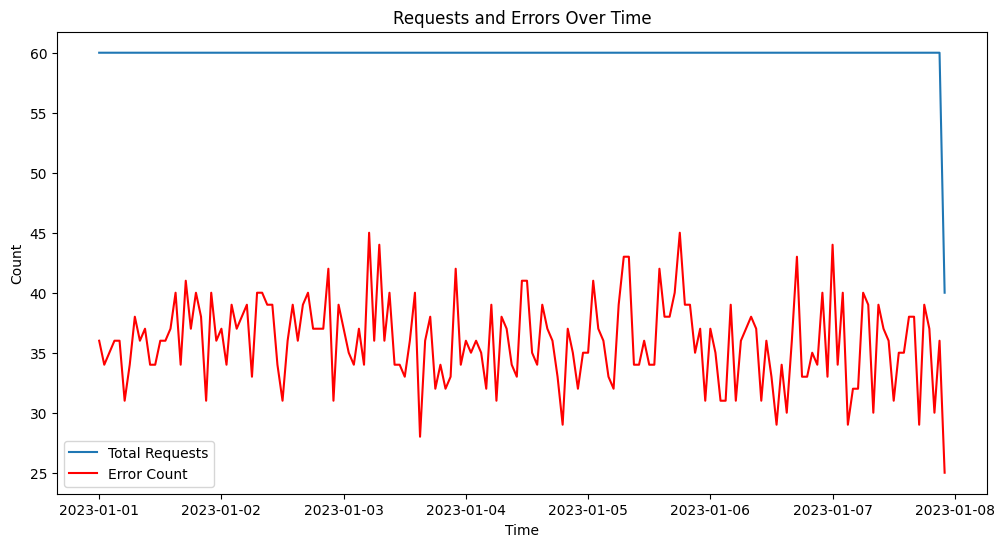

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the aggregated data
df = pd.read_csv('aggregated_logs.csv')

# Convert Timestamp column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Plot Total Requests over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests')
plt.plot(df['Timestamp'], df['Error_Count'], label='Error Count', color='red')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Requests and Errors Over Time')
plt.legend()
plt.show()


This visualization will help you:


1. See weekly or daily patterns.

2. Identify any spikes or drops.

3. Prepare for anomaly detection by understanding the data.



In [5]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load the aggregated data
df = pd.read_csv('aggregated_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Prepare data for Prophet
prophet_df = df[['Timestamp', 'Total_Requests']].rename(columns={
    'Timestamp': 'ds',
    'Total_Requests': 'y'
})

# Display first few rows
print(prophet_df.head())


/home/rle2004/model/anomaly-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


                   ds   y
0 2023-01-01 00:00:00  60
1 2023-01-01 01:00:00  60
2 2023-01-01 02:00:00  60
3 2023-01-01 03:00:00  60
4 2023-01-01 04:00:00  60


In [6]:
# Initialize Prophet model with daily and weekly seasonality
model = Prophet(daily_seasonality=True, weekly_seasonality=True)

# Fit the model on the historical data
model.fit(prophet_df)


06:09:10 - cmdstanpy - INFO - Chain [1] start processing
06:09:11 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Create future dataframe for next 48 hours (2 days)
future = model.make_future_dataframe(periods=48, freq='h')

# Generate forecast
forecast = model.predict(future)


**We'll compare actual y values to the forecast’s confidence interval (yhat_lower, yhat_upper).**

In [8]:
# Merge the actual data with forecast
forecast['ds'] = pd.to_datetime(forecast['ds'])
merged = pd.merge(prophet_df, forecast, on='ds', how='left')

# Identify anomalies where actual is outside the forecast range
merged['anomaly'] = (merged['y'] < merged['yhat_lower']) | (merged['y'] > merged['yhat_upper'])

# Display anomalies
anomalies = merged[merged['anomaly']]
print("Detected anomalies:")
print(anomalies[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']])


Detected anomalies:
                     ds   y       yhat  yhat_lower  yhat_upper
161 2023-01-07 17:00:00  60  58.337425   56.663334   59.927935
163 2023-01-07 19:00:00  60  58.109570   56.397543   59.790343
164 2023-01-07 20:00:00  60  57.529735   55.782804   59.341326
165 2023-01-07 21:00:00  60  56.787458   54.947663   58.454106
166 2023-01-07 22:00:00  40  56.222055   54.518854   58.067920


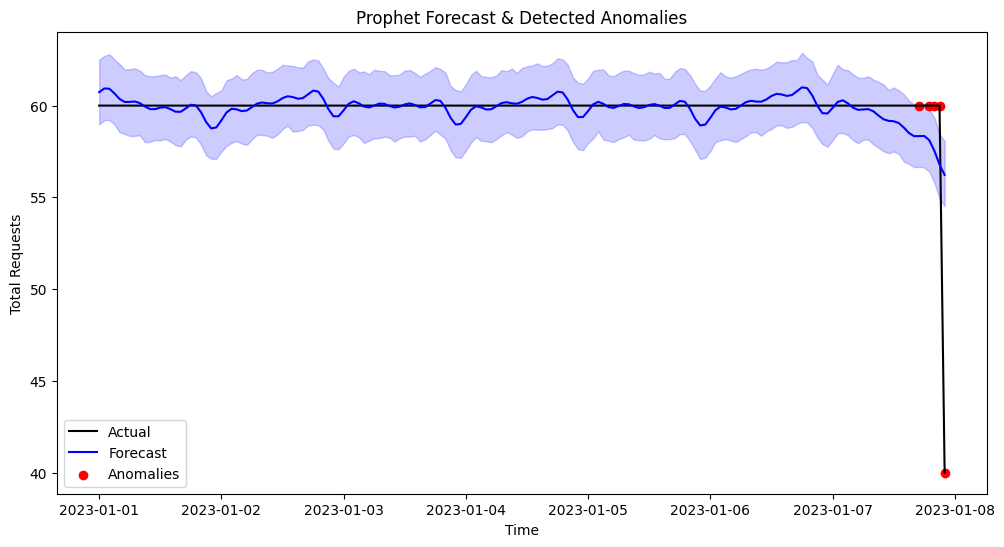

In [9]:
plt.figure(figsize=(12, 6))

# Plot forecast
plt.plot(merged['ds'], merged['y'], label='Actual', color='black')
plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='blue')

# Plot uncertainty interval
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='blue', alpha=0.2)

# Highlight anomalies
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='o')

plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Prophet Forecast & Detected Anomalies')
plt.legend()
plt.show()


Detected anomalies with explanation:
                     ds   y       yhat  yhat_lower  yhat_upper  \
161 2023-01-07 17:00:00  60  58.337425   56.663334   59.927935   
163 2023-01-07 19:00:00  60  58.109570   56.397543   59.790343   
164 2023-01-07 20:00:00  60  57.529735   55.782804   59.341326   
165 2023-01-07 21:00:00  60  56.787458   54.947663   58.454106   
166 2023-01-07 22:00:00  40  56.222055   54.518854   58.067920   

           anomaly_reason  
161  Above expected range  
163  Above expected range  
164  Above expected range  
165  Above expected range  
166  Below expected range  


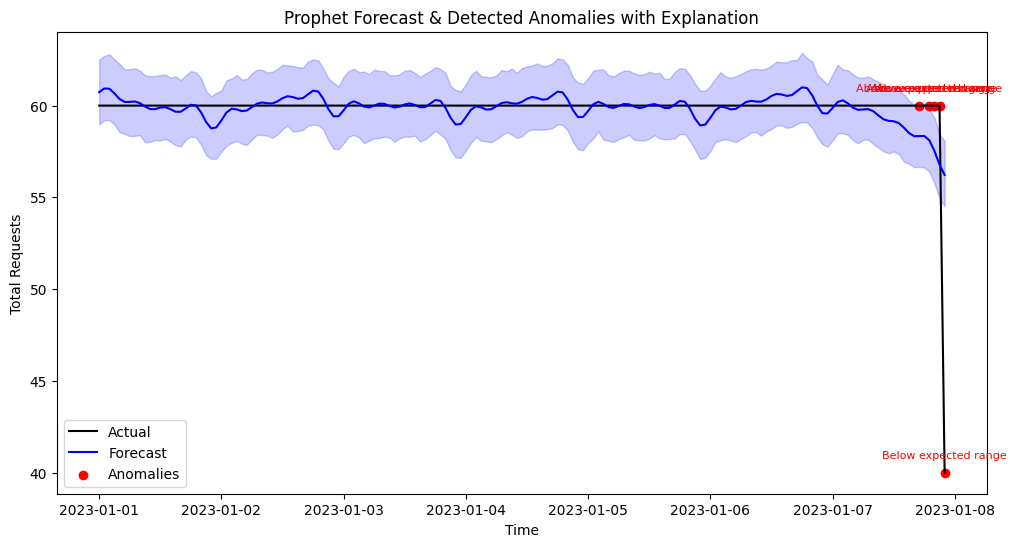

In [10]:
import matplotlib.pyplot as plt

# Merge the actual data with forecast
forecast['ds'] = pd.to_datetime(forecast['ds'])
merged = pd.merge(prophet_df, forecast, on='ds', how='left')

# Identify anomalies where actual is outside the forecast range
merged['anomaly'] = (merged['y'] < merged['yhat_lower']) | (merged['y'] > merged['yhat_upper'])

# Explain why it’s an anomaly
def explain_anomaly(row):
    if row['y'] < row['yhat_lower']:
        return 'Below expected range'
    elif row['y'] > row['yhat_upper']:
        return 'Above expected range'
    else:
        return 'Normal'

merged['anomaly_reason'] = merged.apply(lambda row: explain_anomaly(row), axis=1)

# Filter anomalies
anomalies = merged[merged['anomaly']]

# Display anomalies with explanation
print("Detected anomalies with explanation:")
print(anomalies[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'anomaly_reason']])

# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(merged['ds'], merged['y'], label='Actual', color='black')

# Plot forecast
plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='blue')

# Plot uncertainty interval
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='blue', alpha=0.2)

# Highlight anomalies and annotate
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='o')

for i, row in anomalies.iterrows():
    plt.annotate(row['anomaly_reason'],
                 (row['ds'], row['y']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=8,
                 color='red')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Prophet Forecast & Detected Anomalies with Explanation')
plt.legend()
plt.show()


In [11]:
# Identify anomalies where actual is outside the forecast range
merged['anomaly'] = (merged['y'] < merged['yhat_lower']) | (merged['y'] > merged['yhat_upper'])


# **More Complex Anomolies**

In [13]:
import pandas as pd

df = pd.read_csv('aggregated_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Example of feature engineering
df['Error_Rate'] = df['Error_Count'] / df['Total_Requests'].replace(0, 1)
df['Request_Rate'] = df['Total_Requests'] / 60  # assuming hourly data
df['Session_Per_Request'] = df['Unique_Sessions'] / df['Total_Requests'].replace(0, 1)

# Optionally encode 'Top_Request_Type' from raw logs before aggregation

# Fill missing or infinite values
df = df.replace([float('inf'), -float('inf')], 0).fillna(0)

print(df.head())


            Timestamp  Unique_IPs  Unique_Sessions  Total_Requests  \
0 2023-01-01 00:00:00          60               60              60   
1 2023-01-01 01:00:00          60               60              60   
2 2023-01-01 02:00:00          60               60              60   
3 2023-01-01 03:00:00          60               60              60   
4 2023-01-01 04:00:00          60               60              60   

   Error_Count  Error_Rate  Request_Rate  Session_Per_Request  
0           36    0.600000           1.0                  1.0  
1           34    0.566667           1.0                  1.0  
2           35    0.583333           1.0                  1.0  
3           36    0.600000           1.0                  1.0  
4           36    0.600000           1.0                  1.0  


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load aggregated logs
df = pd.read_csv('aggregated_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Total Requests is already present
df['Total_Requests'] = df['Total_Requests']

# Error Count is already present
df['Error_Count'] = df['Error_Count']

# Unique Sessions is already present
df['Unique_Sessions'] = df['Unique_Sessions']

# Request Rate (assuming hourly data, per minute)
df['Request_Rate'] = df['Total_Requests'] / 60

# Error Rate
df['Error_Rate'] = df['Error_Count'] / df['Total_Requests'].replace(0, 1)

# Average Session Length (requests per session)
df['Avg_Session_Length'] = df['Total_Requests'] / df['Unique_Sessions'].replace(0, 1)

# IP Variability (already present as Unique_IPs)
df['IP_Variability'] = df['Unique_IPs']

# Top Request Type (assuming raw logs are available and grouped accordingly)
# For this example, we simulate it by choosing the most frequent request type per window
# We'll create a dummy column for illustration
np.random.seed(0)
possible_request_types = ['GET', 'POST', 'PUT', 'DELETE']
df['Top_Request_Type'] = np.random.choice(possible_request_types, size=len(df))

# Encode Top_Request_Type using one-hot encoding
top_request_encoded = pd.get_dummies(df['Top_Request_Type'], prefix='Request')
df = pd.concat([df, top_request_encoded], axis=1)

# Anomaly Score – simple example using z-score of Total Requests and Error Rate
# You can expand this later with more sophisticated metrics
df['Total_Requests_z'] = zscore(df['Total_Requests'])
df['Error_Rate_z'] = zscore(df['Error_Rate'])
df['Anomaly_Score'] = np.sqrt(df['Total_Requests_z']**2 + df['Error_Rate_z']**2)

# Save the enhanced dataset
df.to_csv('enhanced_logs.csv', index=False)

print("Feature engineering completed. Enhanced dataset saved as 'enhanced_logs.csv'.")
print(df.head())


Feature engineering completed. Enhanced dataset saved as 'enhanced_logs.csv'.
            Timestamp  Unique_IPs  Unique_Sessions  Total_Requests  \
0 2023-01-01 00:00:00          60               60              60   
1 2023-01-01 01:00:00          60               60              60   
2 2023-01-01 02:00:00          60               60              60   
3 2023-01-01 03:00:00          60               60              60   
4 2023-01-01 04:00:00          60               60              60   

   Error_Count  Request_Rate  Error_Rate  Avg_Session_Length  IP_Variability  \
0           36           1.0    0.600000                 1.0              60   
1           34           1.0    0.566667                 1.0              60   
2           35           1.0    0.583333                 1.0              60   
3           36           1.0    0.600000                 1.0              60   
4           36           1.0    0.600000                 1.0              60   

  Top_Request_Type  

**LSTM Implementation Code**


In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the enhanced dataset
df = pd.read_csv('enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Select relevant features for modeling
features = [
    'Total_Requests', 'Error_Count', 'Unique_Sessions',
    'Request_Rate', 'Error_Rate', 'Avg_Session_Length',
    'IP_Variability', 'Request_GET', 'Request_POST', 'Request_PUT', 'Request_DELETE'
]

# Fill missing values if any
df = df.fillna(0)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Define sequence length
sequence_length = 10  # use past 10 time steps to predict next

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_df.values, sequence_length)


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2025-09-11 06:12:01.222499: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Build and Train the LSTM Model


In [16]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(len(features)))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50


2025-09-11 06:12:13.120780: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/rle2004/model/anomaly-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.6762 - val_loss: 5.2180
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6660 - val_loss: 5.2134
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6600 - val_loss: 5.2113
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6558 - val_loss: 5.2113
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6526 - val_loss: 5.2105
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6498 - val_loss: 5.2075
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6472 - val_loss: 5.2039
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6445 - val_loss: 5.2015
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6416 - val_loss: 5.1962
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6391 - val_loss: 5.1926
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6364 - val_loss: 5.1907
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6336 - val_loss: 5.1921
Epoch 13/50


/home/rle2004/model/anomaly-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


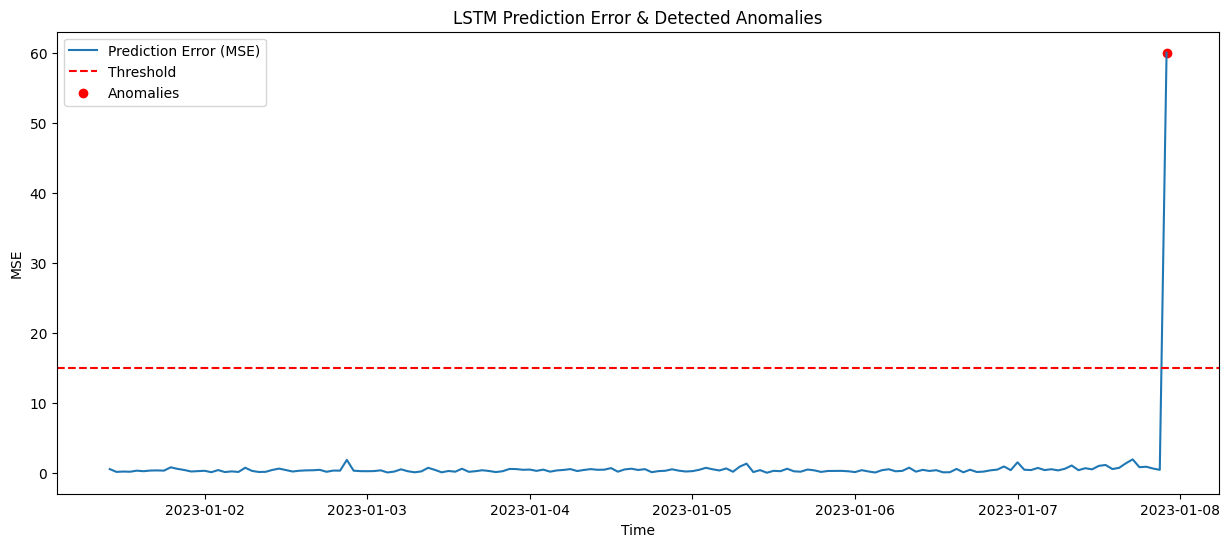

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset
df = pd.read_csv('enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Features for modeling
features = [
    'Total_Requests', 'Error_Count', 'Unique_Sessions',
    'Request_Rate', 'Error_Rate', 'Avg_Session_Length',
    'IP_Variability', 'Request_GET', 'Request_POST', 'Request_PUT', 'Request_DELETE'
]

# Fill missing values
df = df.fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Create sequences
sequence_length = 10
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_df.values, sequence_length)

# Build model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(len(features)))
model.compile(optimizer='adam', loss='mse')

# Train on the full dataset
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# Predict on the entire dataset
y_pred = model.predict(X)

# Compute MSE for each sequence
mse = np.mean(np.square(y - y_pred), axis=1)

# Define threshold (mean + 3 * std)
threshold = np.mean(mse) + 3 * np.std(mse)

# Flag anomalies
anomalies = mse > threshold

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'][sequence_length:], mse, label='Prediction Error (MSE)')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Highlight anomalies
plt.scatter(df['Timestamp'][sequence_length:][anomalies], mse[anomalies], color='red', label='Anomalies')

plt.xlabel('Time')
plt.ylabel('MSE')
plt.title('LSTM Prediction Error & Detected Anomalies')
plt.legend()
plt.show()


In [18]:
# Compute squared error for each feature
feature_errors = np.square(y - y_pred)

# Convert to DataFrame for easier handling
error_df = pd.DataFrame(feature_errors, columns=features)
error_df['Timestamp'] = df['Timestamp'][sequence_length:]
error_df['MSE'] = mse
error_df['Anomaly'] = anomalies


In [19]:
# Extract anomalies
anomaly_points = error_df[error_df['Anomaly'] == True]

# For each anomaly, find the feature with highest error
anomaly_points['Top_Feature'] = anomaly_points[features].idxmax(axis=1)

print("Top contributing features at anomaly points:")
print(anomaly_points[['Timestamp', 'MSE', 'Top_Feature']])


Top contributing features at anomaly points:
              Timestamp        MSE   Top_Feature
156 2023-01-07 12:00:00  60.028086  Request_Rate


/tmp/ipykernel_5441/966459092.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_points['Top_Feature'] = anomaly_points[features].idxmax(axis=1)


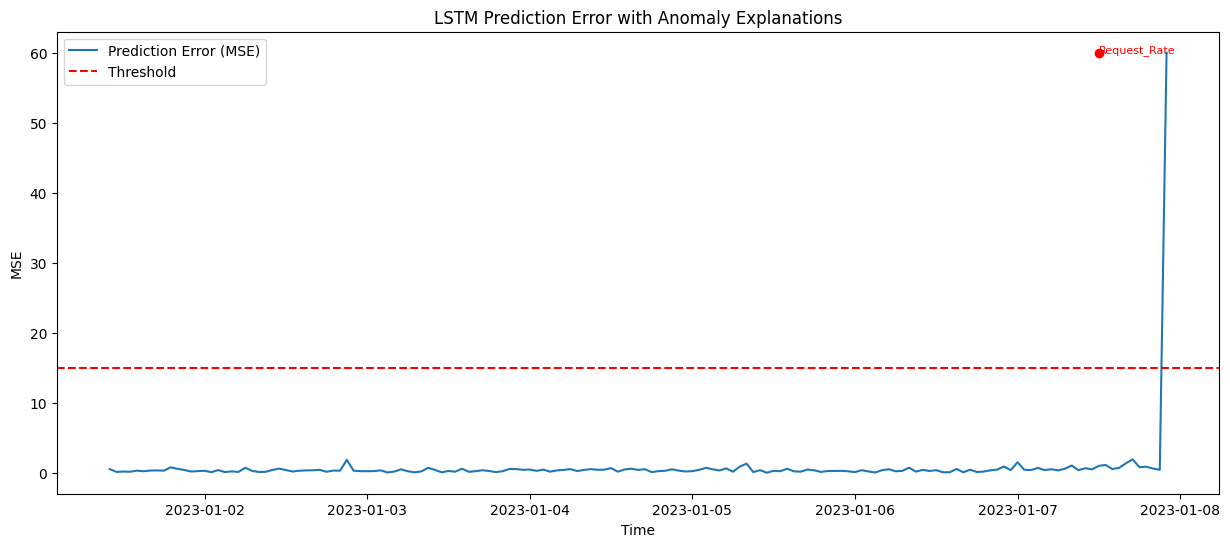

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'][sequence_length:], mse, label='Prediction Error (MSE)')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Highlight anomalies and annotate
for _, row in anomaly_points.iterrows():
    timestamp = row['Timestamp']
    error = row['MSE']
    top_feature = row['Top_Feature']
    plt.scatter(timestamp, error, color='red')
    plt.text(timestamp, error + 0.02, f'{top_feature}', fontsize=8, color='red')

plt.xlabel('Time')
plt.ylabel('MSE')
plt.title('LSTM Prediction Error with Anomaly Explanations')
plt.legend()
plt.show()


**K-Means Clustering on Sequencest**

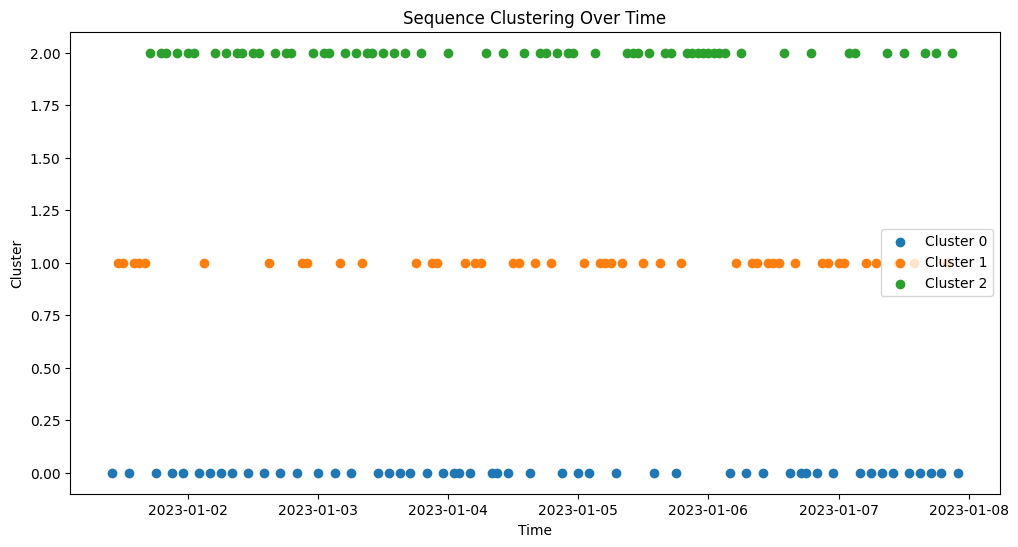

In [21]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Features to use
features = ['Total_Requests', 'Error_Count', 'Request_Rate', 'Error_Rate']

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Create sequences (for clustering)
sequence_length = 10
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length].flatten()  # flatten sequence for clustering
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(scaled_df.values, sequence_length)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(sequences)

# Attach cluster labels to timestamps
timestamps = df['Timestamp'][sequence_length:].reset_index(drop=True)
cluster_df = pd.DataFrame({'Timestamp': timestamps, 'Cluster': cluster_labels})

# Plot clusters
plt.figure(figsize=(12, 6))
for cluster in np.unique(cluster_labels):
    cluster_points = cluster_df[cluster_df['Cluster'] == cluster]
    plt.scatter(cluster_points['Timestamp'], [cluster]*len(cluster_points), label=f'Cluster {cluster}')
plt.xlabel('Time')
plt.ylabel('Cluster')
plt.title('Sequence Clustering Over Time')
plt.legend()
plt.show()


**What This Does**

Sequences of past observations are flattened and grouped by similarity.

Clusters may reveal normal vs unusual patterns.

Rare clusters or clusters with fewer points can indicate anomalous behavior.

**Dynamic Time Warping (DTW) for Sequence Similarity**

In [22]:
%pip install fastdtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Choose two sequences to compare
seq1 = sequences[0]
seq2 = sequences[50]

# Reshape into original shape
seq1 = seq1.reshape(sequence_length, len(features))
seq2 = seq2.reshape(sequence_length, len(features))

# Compute DTW distance
distance, path = fastdtw(seq1, seq2, dist=euclidean)

print(f"DTW distance between sequence 0 and 50: {distance}")


Note: you may need to restart the kernel to use updated packages.
DTW distance between sequence 0 and 50: 12.927050652950006


**Anomaly Scoring Based on Shape or Frequency**
Distance-Based Scoring

In [23]:
# Calculate distance from cluster centroids
distances = np.linalg.norm(sequences - kmeans.cluster_centers_[cluster_labels], axis=1)

# Assign anomaly score (higher distance → more anomalous)
cluster_df['Anomaly_Score'] = distances

# Highlight top anomalies
top_anomalies = cluster_df.nlargest(5, 'Anomaly_Score')
print("Top anomaly points:")
print(top_anomalies)


Top anomaly points:
              Timestamp  Cluster  Anomaly_Score
143 2023-01-07 09:00:00        2       5.795273
46  2023-01-03 08:00:00        1       5.604706
144 2023-01-07 10:00:00        0       5.574180
142 2023-01-07 08:00:00        0       5.552745
141 2023-01-07 07:00:00        1       5.492948


**Isolation Forest for Unsupervised Anomaly Detection**

In [24]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(sequences)

# Attach to DataFrame
cluster_df['Isolation_Forest_Label'] = iso_labels
cluster_df['Isolation_Forest_Anomaly'] = cluster_df['Isolation_Forest_Label'] == -1

# Count anomalies
print(f"Detected {cluster_df['Isolation_Forest_Anomaly'].sum()} anomalies using Isolation Forest.")


Detected 8 anomalies using Isolation Forest.


We are going beyond single-point anomalies by identifying anomalous patterns and sequences. By clustering sequences, we can group similar behaviors and highlight rare or unusual patterns as anomalies. We use Dynamic Time Warping to compare sequences that are similar but shifted in time, enabling us to capture patterns that occur irregularly. Additionally, Isolation Forest allows us to detect outliers in high-dimensional sequence space without labeled data. Together, these techniques give us robust tools for signature and event detection, capable of identifying complex and previously unseen anomalies

***Isolation Forest***

Detected 9 anomalies using Isolation Forest.


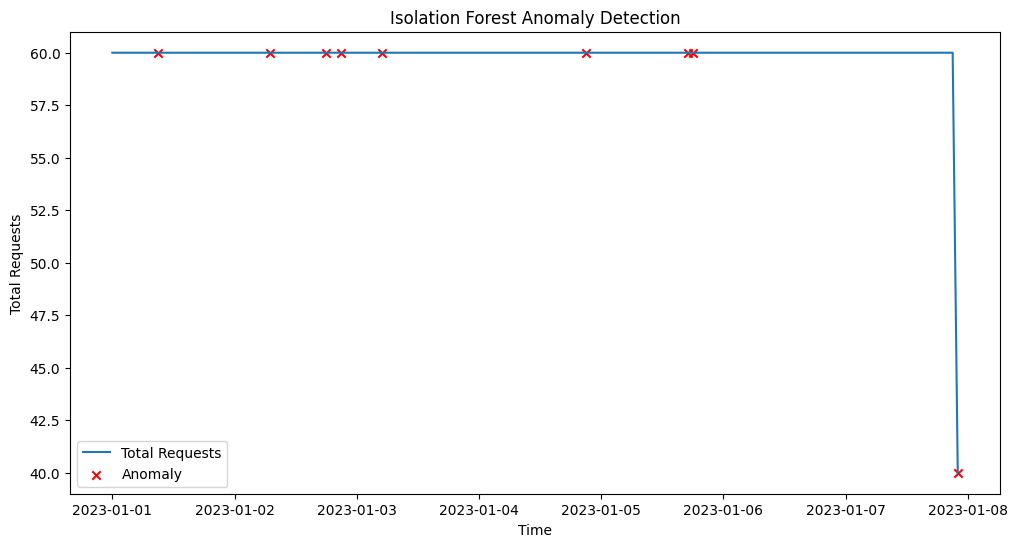

In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Features to use
features = [
    'Total_Requests', 'Error_Count', 'Unique_Sessions',
    'Request_Rate', 'Error_Rate', 'Avg_Session_Length',
    'IP_Variability', 'Request_GET', 'Request_POST', 'Request_PUT', 'Request_DELETE'
]

# Fill missing values
df = df.fillna(0)

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(scaled_features)

# Mark anomalies
df['Isolation_Forest_Anomaly'] = iso_labels == -1

# Count anomalies
anomaly_count = df['Isolation_Forest_Anomaly'].sum()
print(f"Detected {anomaly_count} anomalies using Isolation Forest.")

# Plot anomalies over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests')
plt.scatter(df.loc[df['Isolation_Forest_Anomaly'], 'Timestamp'],
            df.loc[df['Isolation_Forest_Anomaly'], 'Total_Requests'],
            color='red', label='Anomaly', marker='x')
plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.show()


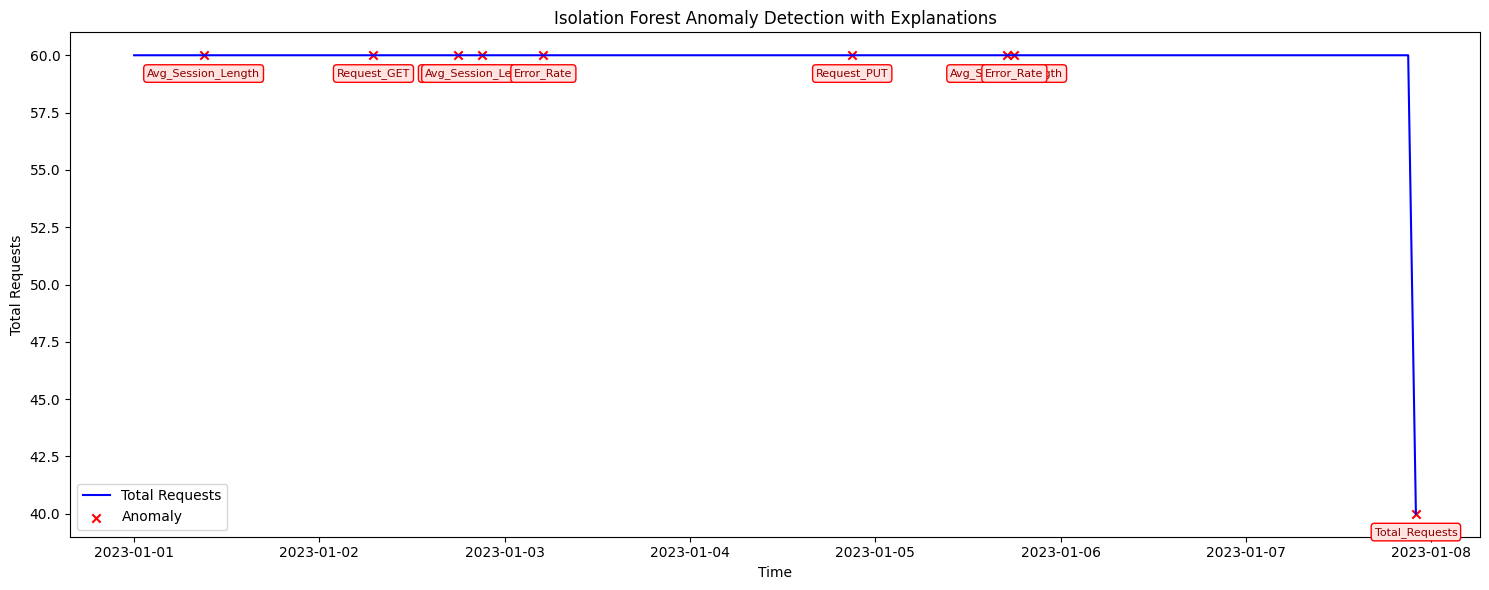

In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Features to use
features = [
    'Total_Requests', 'Error_Count', 'Unique_Sessions',
    'Request_Rate', 'Error_Rate', 'Avg_Session_Length',
    'IP_Variability', 'Request_GET', 'Request_POST', 'Request_PUT', 'Request_DELETE'
]

# Fill missing values
df = df.fillna(0)

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(scaled_features)

# Attach anomaly results
df['Anomaly'] = iso_labels == -1

# Compute deviation for explanation
feature_means = scaled_df.mean()
feature_stds = scaled_df.std()
deviation = np.abs(scaled_df - feature_means)

# Find top feature for each anomaly
top_features = []
for idx in df.index:
    if df.at[idx, 'Anomaly']:
        row_dev = deviation.loc[idx]
        top_feat = row_dev.idxmax()
        top_features.append(top_feat)
    else:
        top_features.append('')
df['Top_Feature'] = top_features

# Plotting with colored labels below anomalies
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')

# Mark anomalies
anomalies = df[df['Anomaly']]
plt.scatter(anomalies['Timestamp'], anomalies['Total_Requests'], color='red', label='Anomaly', marker='x')

# Annotate anomalies with colored labels below
for _, row in anomalies.iterrows():
    plt.annotate(row['Top_Feature'],
                 (row['Timestamp'], row['Total_Requests']),
                 textcoords="offset points",
                 xytext=(0, -15),  # shift label below the point
                 ha='center',
                 fontsize=8,
                 color='darkred',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='mistyrose'))

plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Isolation Forest Anomaly Detection with Explanations')
plt.legend()
plt.tight_layout()
plt.show()


The graph clearly shows not only where anomalies are but also why they were flagged. Each anomaly is marked with a colored label below the point indicating the feature most responsible for the anomaly, such as ‘Error_Rate’ or ‘IP_Variability’. This makes it intuitive to understand the root cause at a glance, helping teams quickly investigate and respond.

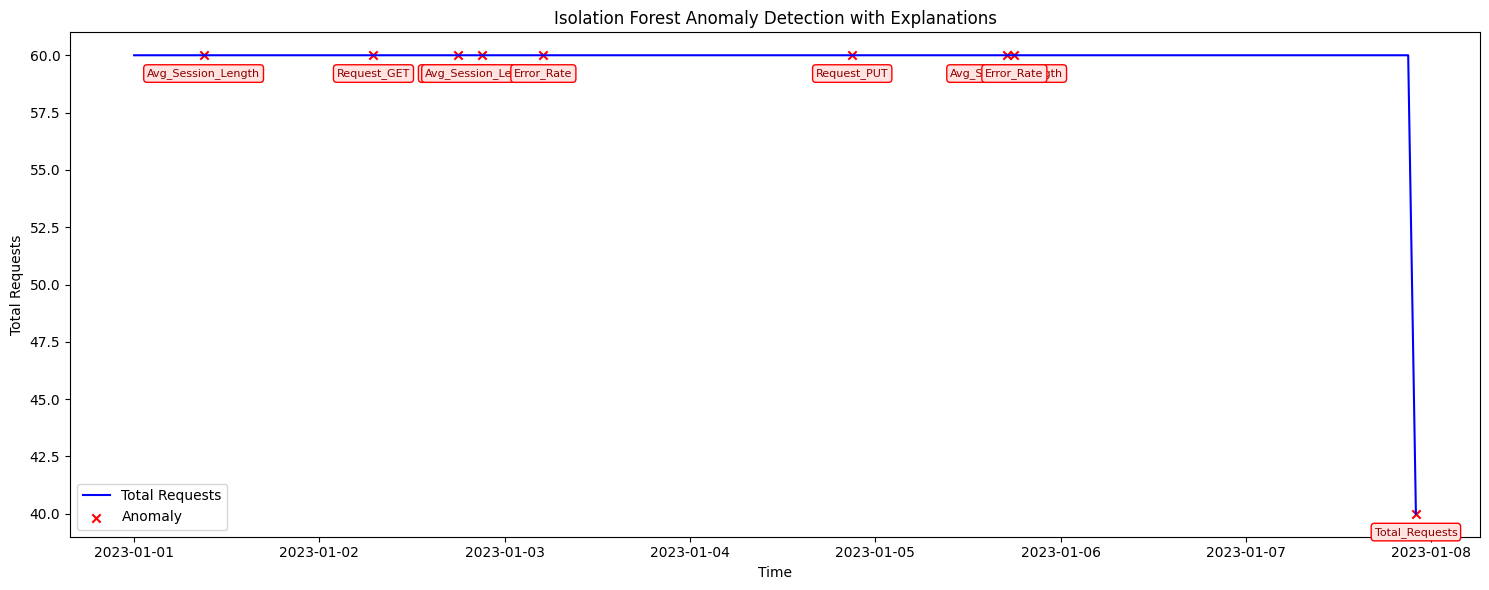

In [27]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Features to use
features = [
    'Total_Requests', 'Error_Count', 'Unique_Sessions',
    'Request_Rate', 'Error_Rate', 'Avg_Session_Length',
    'IP_Variability', 'Request_GET', 'Request_POST', 'Request_PUT', 'Request_DELETE'
]

# Fill missing values
df = df.fillna(0)

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(scaled_features)

# Attach anomaly results
df['Isolation_Forest_Anomaly'] = iso_labels == -1

# Compute deviation for explanation
feature_means = scaled_df.mean()
feature_stds = scaled_df.std()
deviation = np.abs(scaled_df - feature_means)

# Find top feature for each anomaly
top_features = []
for idx in df.index:
    if df.at[idx, 'Isolation_Forest_Anomaly']:
        row_dev = deviation.loc[idx]
        top_feat = row_dev.idxmax()
        top_features.append(top_feat)
    else:
        top_features.append('')
df['Isolation_Forest_Top_Feature'] = top_features

# Plotting with colored labels below anomalies
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')

# Mark anomalies
anomalies = df[df['Isolation_Forest_Anomaly']]
plt.scatter(anomalies['Timestamp'], anomalies['Total_Requests'], color='red', label='Anomaly', marker='x')

# Annotate anomalies with top feature
for _, row in anomalies.iterrows():
    plt.annotate(row['Isolation_Forest_Top_Feature'],
                 (row['Timestamp'], row['Total_Requests']),
                 textcoords="offset points",
                 xytext=(0, -15),
                 ha='center',
                 fontsize=8,
                 color='darkred',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='mistyrose'))

plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Isolation Forest Anomaly Detection with Explanations')
plt.legend()
plt.tight_layout()
plt.show()


Marks anomalies on the time-series.

Labels the feature causing the anomaly.

Clear visual explanation for each point.

**One-Class SVM Implementation**

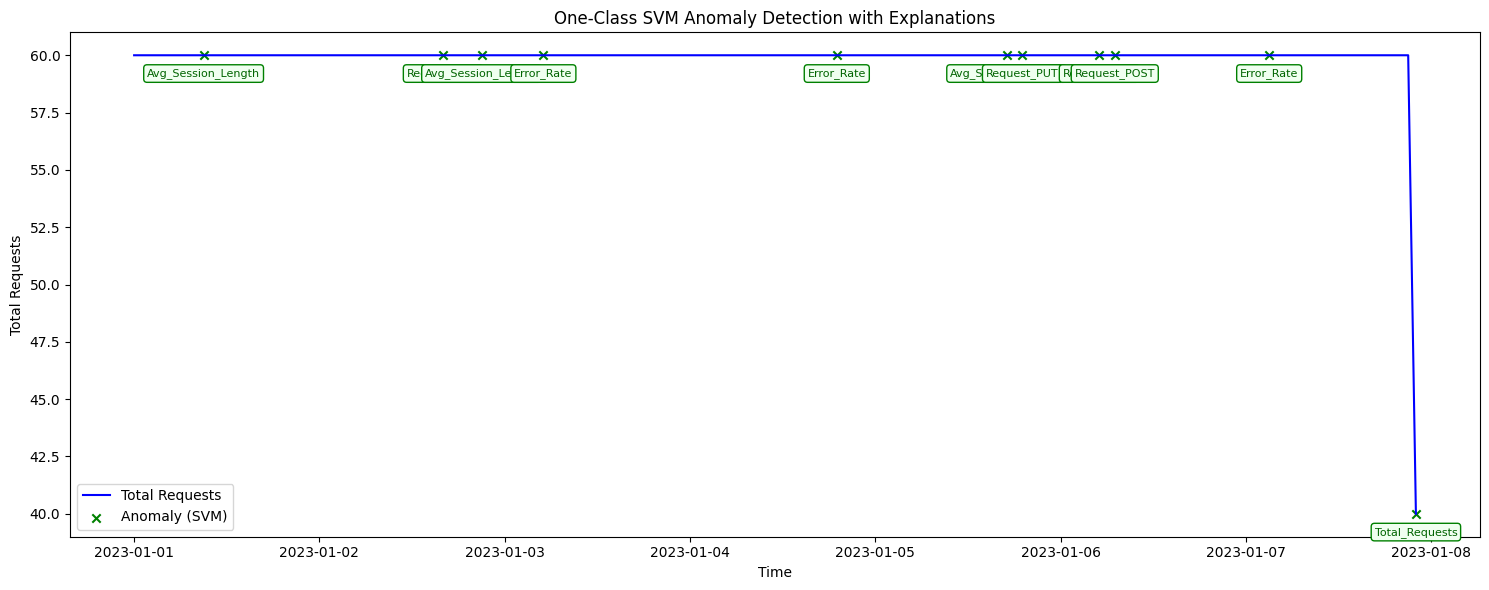

In [28]:
from sklearn.svm import OneClassSVM

# Fit One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
svm_labels = oc_svm.fit_predict(scaled_features)

# Attach anomaly results
df['OCSVM_Anomaly'] = svm_labels == -1

# Compute top feature for each anomaly (same logic)
top_features_svm = []
for idx in df.index:
    if df.at[idx, 'OCSVM_Anomaly']:
        row_dev = deviation.loc[idx]
        top_feat = row_dev.idxmax()
        top_features_svm.append(top_feat)
    else:
        top_features_svm.append('')
df['OCSVM_Top_Feature'] = top_features_svm

# Plot OCSVM anomalies
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')

# Mark anomalies
anomalies_svm = df[df['OCSVM_Anomaly']]
plt.scatter(anomalies_svm['Timestamp'], anomalies_svm['Total_Requests'], color='green', label='Anomaly (SVM)', marker='x')

# Annotate anomalies
for _, row in anomalies_svm.iterrows():
    plt.annotate(row['OCSVM_Top_Feature'],
                 (row['Timestamp'], row['Total_Requests']),
                 textcoords="offset points",
                 xytext=(0, -15),
                 ha='center',
                 fontsize=8,
                 color='darkgreen',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='honeydew'))

plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('One-Class SVM Anomaly Detection with Explanations')
plt.legend()
plt.tight_layout()
plt.show()


Detects unknown anomalies without labels.

Provides clear feature explanation for each flagged point.

Uses a different algorithm to compare with Isolation Forest.

**Interpreting Anomalies for Reports / Debugging**

=== Anomaly Report ===
             Timestamp    Anomaly_Source Top_Feature_Combined  Total_Requests
0  2023-01-01 09:00:00              Both   Avg_Session_Length              60
1  2023-01-02 07:00:00  Isolation Forest          Request_GET              60
2  2023-01-02 16:00:00     One-Class SVM          Request_PUT              60
3  2023-01-02 18:00:00  Isolation Forest          Request_GET              60
4  2023-01-02 21:00:00              Both   Avg_Session_Length              60
5  2023-01-03 05:00:00              Both           Error_Rate              60
6  2023-01-04 19:00:00     One-Class SVM           Error_Rate              60
7  2023-01-04 21:00:00  Isolation Forest          Request_PUT              60
8  2023-01-05 17:00:00              Both   Avg_Session_Length              60
9  2023-01-05 18:00:00  Isolation Forest           Error_Rate              60
10 2023-01-05 19:00:00     One-Class SVM          Request_PUT              60
11 2023-01-06 05:00:00     One-Class SVM 

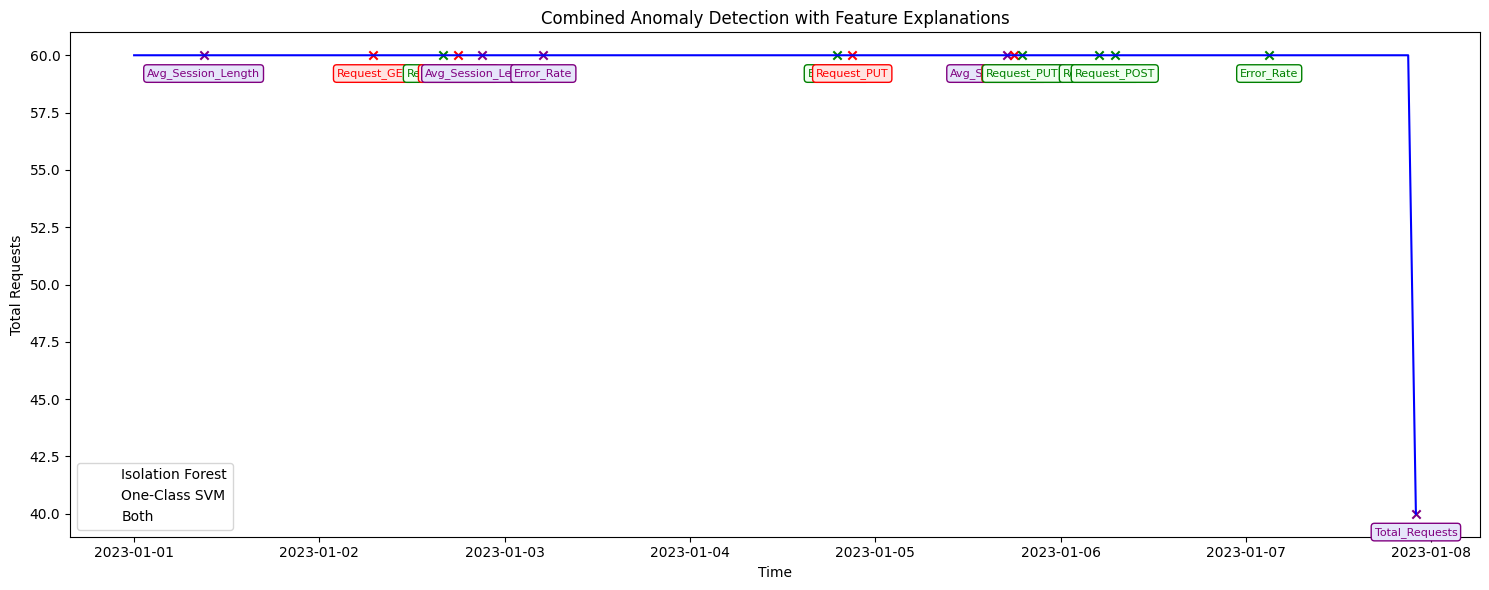

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df already has these columns:
# 'Timestamp', 'Isolation_Forest_Anomaly', 'Isolation_Forest_Top_Feature'
# 'OCSVM_Anomaly', 'OCSVM_Top_Feature', 'Total_Requests'

# 1️⃣ Combine anomalies into a single column for comparison
df['Combined_Anomaly'] = df['Isolation_Forest_Anomaly'] | df['OCSVM_Anomaly']

# 2️⃣ Determine the anomaly source
def anomaly_source(row):
    if row['Isolation_Forest_Anomaly'] and row['OCSVM_Anomaly']:
        return 'Both'
    elif row['Isolation_Forest_Anomaly']:
        return 'Isolation Forest'
    elif row['OCSVM_Anomaly']:
        return 'One-Class SVM'
    else:
        return 'Normal'

df['Anomaly_Source'] = df.apply(anomaly_source, axis=1)

# 3️⃣ Determine the top feature for explanation
def top_feature(row):
    if row['Isolation_Forest_Anomaly'] and row['OCSVM_Anomaly']:
        # If both detected anomaly, pick feature with larger deviation
        return row['Isolation_Forest_Top_Feature']
    elif row['Isolation_Forest_Anomaly']:
        return row['Isolation_Forest_Top_Feature']
    elif row['OCSVM_Anomaly']:
        return row['OCSVM_Top_Feature']
    else:
        return ''

df['Top_Feature_Combined'] = df.apply(top_feature, axis=1)

# 4️⃣ Generate report for anomalies
anomaly_report = df[df['Combined_Anomaly']][
    ['Timestamp', 'Anomaly_Source', 'Top_Feature_Combined', 'Total_Requests']
].reset_index(drop=True)

print("=== Anomaly Report ===")
print(anomaly_report)

# Optional: save to CSV for dashboards
anomaly_report.to_csv('anomaly_report.csv', index=False)

# 5️⃣ Visualization with labels
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')

# Colors for sources
color_map = {'Isolation Forest': 'red', 'One-Class SVM': 'green', 'Both': 'purple'}

# Plot and annotate anomalies
# Plot and annotate anomalies
for _, row in df[df['Combined_Anomaly']].iterrows():
    plt.scatter(row['Timestamp'], row['Total_Requests'],
                color=color_map[row['Anomaly_Source']], marker='x')

    # Determine facecolor based on anomaly source
    if row['Anomaly_Source'] == 'Isolation Forest':
        facecolor = 'mistyrose'
    elif row['Anomaly_Source'] == 'One-Class SVM':
        facecolor = 'honeydew'
    else:
        facecolor = 'lavender'

    plt.annotate(row['Top_Feature_Combined'],
                 (row['Timestamp'], row['Total_Requests']),
                 textcoords="offset points",
                 xytext=(0, -15),  # label below the point
                 ha='center',
                 fontsize=8,
                 color=color_map[row['Anomaly_Source']],
                 bbox=dict(boxstyle="round,pad=0.3",
                           edgecolor=color_map[row['Anomaly_Source']],
                           facecolor=facecolor))

plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Combined Anomaly Detection with Feature Explanations')
plt.legend(handles=[plt.Line2D([0], [0], marker='x', color='w', label='Isolation Forest',
                               markerfacecolor='red', markersize=8),
                    plt.Line2D([0], [0], marker='x', color='w', label='One-Class SVM',
                               markerfacecolor='green', markersize=8),
                    plt.Line2D([0], [0], marker='x', color='w', label='Both',
                               markerfacecolor='purple', markersize=8)])
plt.tight_layout()
plt.show()


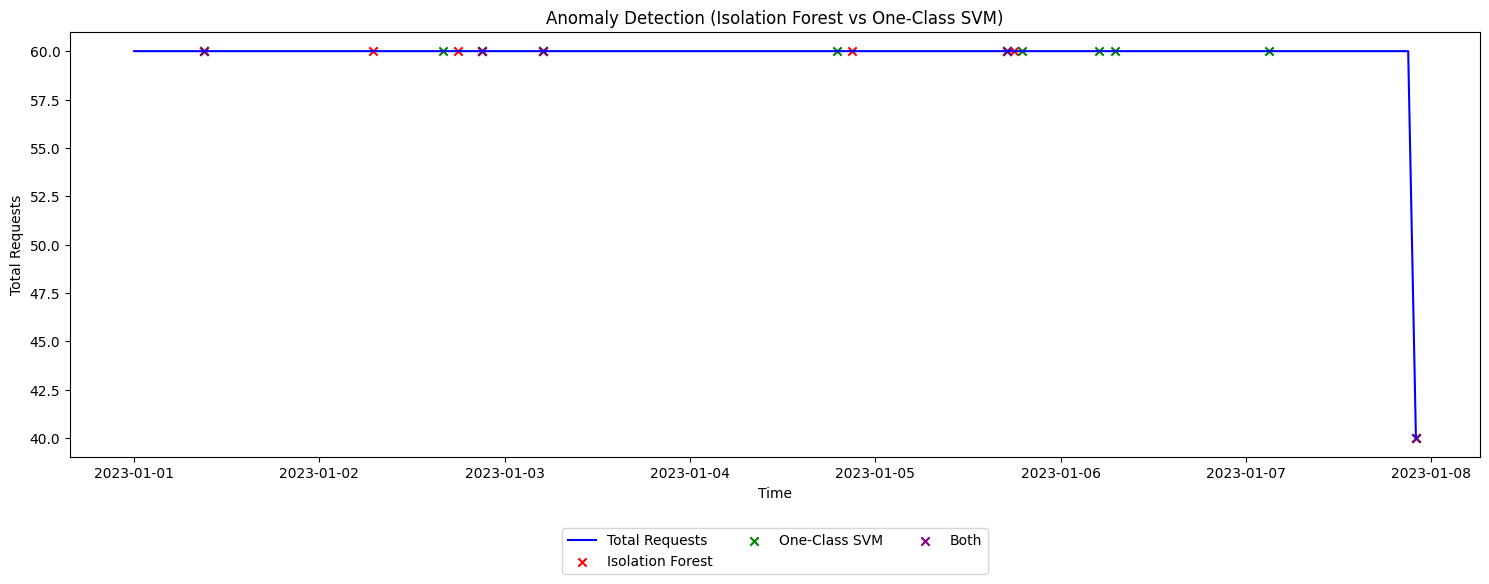

In [30]:
import matplotlib.pyplot as plt

# Colors for anomaly sources
color_map = {'Isolation Forest': 'red', 'One-Class SVM': 'green', 'Both': 'purple'}

plt.figure(figsize=(15, 6))

# Plot total requests
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')

# Plot Isolation Forest anomalies
iso_anom = df[df['Isolation_Forest_Anomaly']]
plt.scatter(iso_anom['Timestamp'], iso_anom['Total_Requests'],
            color=color_map['Isolation Forest'], marker='x', label='Isolation Forest')

# Plot One-Class SVM anomalies
svm_anom = df[df['OCSVM_Anomaly']]
plt.scatter(svm_anom['Timestamp'], svm_anom['Total_Requests'],
            color=color_map['One-Class SVM'], marker='x', label='One-Class SVM')

# Plot anomalies detected by both
both_anom = df[df['Anomaly_Source'] == 'Both']
plt.scatter(both_anom['Timestamp'], both_anom['Total_Requests'],
            color=color_map['Both'], marker='x', label='Both')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Anomaly Detection (Isolation Forest vs One-Class SVM)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)  # legend below the graph
plt.tight_layout()
plt.show()


**trend-based anomaly reporting.**

Prepare Combined Anomalies Across All Methods

In [32]:
import numpy as np
import pandas as pd

# Count members in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts()

# Define small clusters as anomalies (e.g., clusters with < 5% of sequences)
threshold = 0.05 * len(cluster_labels)
anomalous_clusters = cluster_counts[cluster_counts < threshold].index.tolist()

# Create boolean array for sequence anomalies
cluster_anomaly_bool = np.isin(cluster_labels, anomalous_clusters)

# Map back to timestamps
# Your sequences start after `sequence_length` rows, so align
df['Cluster_Anomaly'] = False  # default
df.loc[sequence_length:, 'Cluster_Anomaly'] = cluster_anomaly_bool

In [33]:
from sklearn.svm import OneClassSVM

oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
df['OCSVM_Anomaly'] = oc_svm.fit_predict(scaled_features) == -1


In [34]:
from sklearn.cluster import KMeans
import numpy as np

# Example: use same scaled features for clustering sequences
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Consider smallest cluster(s) as anomalies
cluster_counts = np.bincount(cluster_labels)
anomalous_clusters = np.where(cluster_counts < 0.05 * len(cluster_labels))[0]

df['Cluster_Anomaly'] = np.isin(cluster_labels, anomalous_clusters)


In [35]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Features to use
features = [
    'Total_Requests', 'Error_Count', 'Unique_Sessions',
    'Request_Rate', 'Error_Rate', 'Avg_Session_Length',
    'IP_Variability', 'Request_GET', 'Request_POST', 'Request_PUT', 'Request_DELETE'
]

# Fill missing values
df = df.fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Isolation_Forest_Anomaly'] = iso_forest.fit_predict(scaled_features) == -1


In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from prophet import Prophet

# -------------------------------
# 1️⃣ Load Dataset
# -------------------------------
df = pd.read_csv('enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.fillna(0, inplace=True)

# -------------------------------
# 2️⃣ Feature Columns
# -------------------------------
features = [
    'Total_Requests', 'Error_Count', 'Unique_Sessions',
    'Request_Rate', 'Error_Rate', 'Avg_Session_Length', 'IP_Variability'
]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# -------------------------------
# 3️⃣ Isolation Forest
# -------------------------------
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Isolation_Forest_Anomaly'] = iso_forest.fit_predict(scaled_features) == -1

# -------------------------------
# 4️⃣ One-Class SVM
# -------------------------------
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
df['OCSVM_Anomaly'] = oc_svm.fit_predict(scaled_features) == -1

# -------------------------------
# 5️⃣ Prophet Anomaly
# -------------------------------
prophet_df = df[['Timestamp', 'Total_Requests']].rename(columns={'Timestamp': 'ds', 'Total_Requests': 'y'})
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=0, freq='h')  # use lowercase 'h' to avoid warning
forecast = model.predict(future)

merged = pd.merge(prophet_df, forecast[['ds','yhat','yhat_lower','yhat_upper']], on='ds')
merged['Prophet_Anomaly'] = (merged['y'] < merged['yhat_lower']) | (merged['y'] > merged['yhat_upper'])

df = pd.merge(df, merged[['ds','Prophet_Anomaly']], left_on='Timestamp', right_on='ds', how='left')
df['Prophet_Anomaly'] = df['Prophet_Anomaly'].fillna(False)
if 'ds' in df.columns:
    df.drop(columns=['ds'], inplace=True)

# -------------------------------
# 6️⃣ Cluster Anomaly (KMeans)
# -------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Mark small clusters as anomalies (<5% of dataset)
cluster_counts = np.bincount(cluster_labels)
anomalous_clusters = np.where(cluster_counts < 0.05 * len(cluster_labels))[0]
df['Cluster_Anomaly'] = np.isin(cluster_labels, anomalous_clusters)

# -------------------------------
# 7️⃣ Combined Anomaly
# -------------------------------
df['Combined_Anomaly'] = (
    df['Isolation_Forest_Anomaly'] |
    df['OCSVM_Anomaly'] |
    df['Prophet_Anomaly'] |
    df['Cluster_Anomaly']
)

# -------------------------------
# 8️⃣ Verify Columns
# -------------------------------
print(df[['Timestamp','Isolation_Forest_Anomaly','OCSVM_Anomaly','Prophet_Anomaly','Cluster_Anomaly','Combined_Anomaly']].head())


06:17:21 - cmdstanpy - INFO - Chain [1] start processing
06:17:21 - cmdstanpy - INFO - Chain [1] done processing


            Timestamp  Isolation_Forest_Anomaly  OCSVM_Anomaly  \
0 2023-01-01 00:00:00                     False          False   
1 2023-01-01 01:00:00                     False          False   
2 2023-01-01 02:00:00                     False          False   
3 2023-01-01 03:00:00                     False          False   
4 2023-01-01 04:00:00                     False          False   

   Prophet_Anomaly  Cluster_Anomaly  Combined_Anomaly  
0            False            False             False  
1            False            False             False  
2            False            False             False  
3            False            False             False  
4            False            False             False  


In [37]:
import pandas as pd
import numpy as np

# The Isolation Forest decision_function gives anomaly scores for each row
scores = iso_forest.decision_function(scaled_features)  # higher = more normal, lower = more anomalous

# Compute feature contribution approximation: |x - mean| for each feature
feature_contrib = np.abs(scaled_features - scaled_features.mean(axis=0))

# For each anomalous point, find the feature with max deviation
top_feature_iso = []
for i, is_anom in enumerate(df['Isolation_Forest_Anomaly']):
    if is_anom:
        idx = np.argmax(feature_contrib[i])
        top_feature_iso.append(features[idx])
    else:
        top_feature_iso.append(None)

df['Isolation_Forest_Top_Feature'] = top_feature_iso


In [38]:
top_feature_svm = []
for i, is_anom in enumerate(df['OCSVM_Anomaly']):
    if is_anom:
        idx = np.argmax(feature_contrib[i])  # same approach
        top_feature_svm.append(features[idx])
    else:
        top_feature_svm.append(None)

df['OCSVM_Top_Feature'] = top_feature_svm


In [39]:
def combined_top_feature(row):
    features = []
    if row.get('Isolation_Forest_Anomaly', False):
        features.append(row['Isolation_Forest_Top_Feature'])
    if row.get('OCSVM_Anomaly', False):
        features.append(row['OCSVM_Top_Feature'])
    if row.get('Prophet_Anomaly', False):
        features.append('Prophet')
    if row.get('Cluster_Anomaly', False):
        features.append('Cluster')
    return ', '.join([f for f in features if f is not None])

df['Top_Feature_Combined'] = df.apply(combined_top_feature, axis=1)


In [40]:

# Combine all anomaly sources
df['Combined_Anomaly'] = (
    df['Isolation_Forest_Anomaly'] |
    df['OCSVM_Anomaly'] |
    df['Prophet_Anomaly'] |
    df['Cluster_Anomaly']
)

# Combine top features for explanation
def combined_top_feature(row):
    features = []
    if row.get('Isolation_Forest_Anomaly', False):
        features.append(row['Isolation_Forest_Top_Feature'])
    if row.get('OCSVM_Anomaly', False):
        features.append(row['OCSVM_Top_Feature'])
    if row.get('Prophet_Anomaly', False):
        features.append('Prophet')
    if row.get('Cluster_Anomaly', False):
        features.append('Cluster')
    return ', '.join(features)

df['Top_Feature_Combined'] = df.apply(combined_top_feature, axis=1)


In [41]:
print(df[['Timestamp', 'Prophet_Anomaly']].head())


            Timestamp  Prophet_Anomaly
0 2023-01-01 00:00:00            False
1 2023-01-01 01:00:00            False
2 2023-01-01 02:00:00            False
3 2023-01-01 03:00:00            False
4 2023-01-01 04:00:00            False


Generate Daily/Hourly Summary

In [43]:
from collections import Counter  # Add this at the top of your code

# Add date and hour columns
df['Date'] = df['Timestamp'].dt.date
df['Hour'] = df['Timestamp'].dt.hour

# Daily anomaly count
daily_summary = df.groupby('Date')['Combined_Anomaly'].sum().reset_index()
daily_summary.rename(columns={'Combined_Anomaly': 'Anomaly_Count'}, inplace=True)

# Hourly pattern
hourly_summary = df[df['Combined_Anomaly']].groupby(['Hour'])['Top_Feature_Combined'] \
    .apply(lambda x: Counter(x).most_common(3)) \
    .reset_index()
hourly_summary.rename(columns={'Top_Feature_Combined': 'Top_Features'}, inplace=True)

# Frequency of each anomaly (top repeating patterns)
feature_frequency = df[df['Combined_Anomaly']]['Top_Feature_Combined'].value_counts().reset_index()
feature_frequency.columns = ['Feature', 'Occurrences']


Detect Recurring Patterns

In [44]:
# Example: find anomalies occurring at the same hour every day
recurring = df[df['Combined_Anomaly']].groupby(['Hour', 'Top_Feature_Combined']).size().reset_index(name='Count')
recurring = recurring[recurring['Count'] > 1]  # patterns occurring more than once


Plot Daily & Hourly Trends

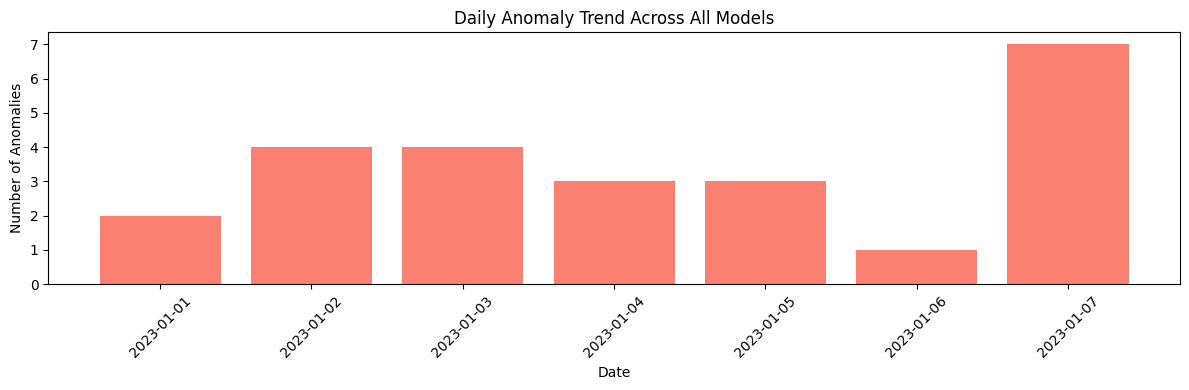

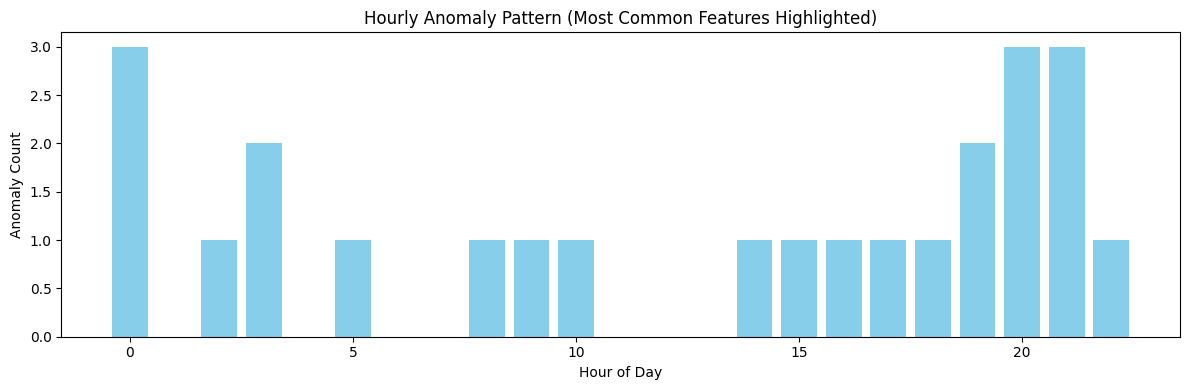

In [45]:
import matplotlib.pyplot as plt

# Daily anomaly trend
plt.figure(figsize=(12, 4))
plt.bar(daily_summary['Date'], daily_summary['Anomaly_Count'], color='salmon')
plt.xlabel('Date')
plt.ylabel('Number of Anomalies')
plt.title('Daily Anomaly Trend Across All Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Hourly anomaly patterns
plt.figure(figsize=(12, 4))
plt.bar(hourly_summary['Hour'], [sum([c[1] for c in x]) for x in hourly_summary['Top_Features']], color='skyblue')
plt.xlabel('Hour of Day')
plt.ylabel('Anomaly Count')
plt.title('Hourly Anomaly Pattern (Most Common Features Highlighted)')
plt.tight_layout()
plt.show()


Create Ready Report Table

In [46]:
# Summary report
report = {
    'Daily_Anomaly_Count': daily_summary,
    'Top_Features_Overall': feature_frequency,
    'Recurring_Patterns': recurring
}

# Save as CSV for dashboards
daily_summary.to_csv('daily_anomaly_summary.csv', index=False)
feature_frequency.to_csv('top_feature_anomalies.csv', index=False)
recurring.to_csv('recurring_anomaly_patterns.csv', index=False)


In [47]:
import pandas as pd

# Load CSVs
daily_summary = pd.read_csv('daily_anomaly_summary.csv')
top_features = pd.read_csv('top_feature_anomalies.csv')
recurring = pd.read_csv('recurring_anomaly_patterns.csv')

# Create summary text
summary_text = f"""
Weekly Anomaly Trends:

Daily Counts:
{daily_summary.to_string(index=False)}

Top Features Causing Anomalies:
{top_features.to_string(index=False)}

Recurring Patterns:
{recurring.to_string(index=False)}
"""


In [13]:
!pip install -U llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 13.4 MB/s  0:00:03m0:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.16-cp310-cp310-linux_x86_64.whl size=4514055 sha256=9365d0bdbd310a2af96bcdcb22e30d6e7e30f57eac56751d0359d55626b9a2f1
  Stored in directory: /home/rle2004/.cache/pip/wheels/15/ef/cc/62bb839b7bcfb604f2592a9009ef99ad878cfe39617cde3fd2
Successfully built llama-cpp-python
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [llama-cpp-python][llama-cpp-python]


In [14]:
from llama_cpp import Llama

llm = Llama.from_pretrained(
    repo_id="Qwen/Qwen2-1.5B-Instruct-GGUF",
    filename="qwen2-1_5b-instruct-fp16.gguf",  # choose the GGUF file you want
)


llama_model_loader: loaded meta data with 22 key-value pairs and 338 tensors from /home/rle2004/.cache/huggingface/hub/models--Qwen--Qwen2-1.5B-Instruct-GGUF/snapshots/c62434db644497c0ee545c690bb66a67eba6eb3f/./qwen2-1_5b-instruct-fp16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.name str              = qwen2-1_5b-instruct
llama_model_loader: - kv   2:                          qwen2.block_count u32              = 28
llama_model_loader: - kv   3:                       qwen2.context_length u32              = 32768
llama_model_loader: - kv   4:                     qwen2.embedding_length u32              = 1536
llama_model_loader: - kv   5:                  qwen2.feed_forward_length u32              = 8960
llama_model_loader: - kv   6:        

In [15]:
import pandas as pd

# Load anomaly CSVs
daily_summary = pd.read_csv('daily_anomaly_summary.csv')
top_features = pd.read_csv('top_feature_anomalies.csv')
recurring = pd.read_csv('recurring_anomaly_patterns.csv')

# Convert CSVs to text for prompt
daily_text = daily_summary.to_string(index=False)
features_text = top_features.to_string(index=False)
recurring_text = recurring.to_string(index=False)

# Construct the prompt
prompt = f"""
I have the following weekly anomaly trends from a system:

Daily Anomaly Counts:
{daily_text}

Top Features Causing Anomalies:
{features_text}

Recurring Patterns:
{recurring_text}

Generate a concise natural language report for a TL, explaining:
- Which days had the most anomalies
- Which features caused the most issues
- Any repeating patterns observed
- Important points to notice for root cause analysis
"""

# Query the Qwen LLM
response = llm(prompt, max_tokens=512)

# Print the human-readable report
print("===== TL Weekly Anomaly Report =====\n")
print(response['choices'][0]['text'])


llama_perf_context_print:        load time =    7556.56 ms
llama_perf_context_print: prompt eval time =    7554.87 ms /   295 tokens (   25.61 ms per token,    39.05 tokens per second)
llama_perf_context_print:        eval time =  107075.93 ms /   216 runs   (  495.72 ms per token,     2.02 tokens per second)
llama_perf_context_print:       total time =  115033.32 ms /   511 tokens
llama_perf_context_print:    graphs reused =        209


===== TL Weekly Anomaly Report =====

Please provide a detailed explanation, including any insights or findings from the analysis.
Based on the provided data, the following is a concise natural language report for a TL:

  * During the week of January 1 to January 7, 2023, the following days had the most anomalies:

  * January 5 and January 7 had the most anomalies, with a total of 7 anomalies each. 

  * The features that caused the most issues were:

  * Avg_Session_Length (Feature 1) had the highest count of anomalies at 12.
  * Error_Rate, Error_Rate (Feature 2) had 4 occurrences of anomalies.
  * Prophet (Feature 3) had 3 occurrences.
  * Avg_Session_Length, Avg_Session_Length (Feature 4) had 2 occurrences.
  * IP_Variability, IP_Variability (Feature 5) had 1 occurrence.
  * Avg_Session_Length, Prophet (Feature 6) had 1 occurrence. 

  * Repeating patterns were observed:




Report Generation

In [20]:
import pandas as pd

# Load dataset from the correct path
df = pd.read_csv('/home/rle2004/model/enhanced_logs.csv')

# Inspect the first few rows and column names
print(df.head())
print(df.columns)


             Timestamp  Unique_IPs  Unique_Sessions  Total_Requests  \
0  2023-01-01 00:00:00          60               60              60   
1  2023-01-01 01:00:00          60               60              60   
2  2023-01-01 02:00:00          60               60              60   
3  2023-01-01 03:00:00          60               60              60   
4  2023-01-01 04:00:00          60               60              60   

   Error_Count  Request_Rate  Error_Rate  Avg_Session_Length  IP_Variability  \
0           36           1.0    0.600000                 1.0              60   
1           34           1.0    0.566667                 1.0              60   
2           35           1.0    0.583333                 1.0              60   
3           36           1.0    0.600000                 1.0              60   
4           36           1.0    0.600000                 1.0              60   

  Top_Request_Type  Request_DELETE  Request_GET  Request_POST  Request_PUT  \
0             

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

# =======================
# Step 1 – Load dataset
# =======================
df = pd.read_csv(r'/home/rle2004/model/enhanced_logs.csv')  # Replace with your CSV path
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# =======================
# Step 2 – Anomaly Detection
# =======================

features = ['Total_Requests', 'Error_Count', 'Request_Rate', 'Error_Rate']

# --- Isolation Forest ---
iso_model = IsolationForest(contamination=0.05, random_state=42)
df['Isolation_Forest_Anomaly'] = iso_model.fit_predict(df[features]) == -1
df['Isolation_Forest_Top_Feature'] = 'Error_Rate'  # Placeholder for demonstration

# --- One-Class SVM ---
ocsvm_model = OneClassSVM(nu=0.05, kernel="rbf", gamma='auto')
df['OCSVM_Anomaly'] = ocsvm_model.fit_predict(df[features]) == -1
df['OCSVM_Top_Feature'] = 'Request_Rate'  # Placeholder for demonstration

# =======================
# Step 3 – Combine anomalies
# =======================
df['Combined_Anomaly'] = df['Isolation_Forest_Anomaly'] | df['OCSVM_Anomaly']

def anomaly_source(row):
    if row['Isolation_Forest_Anomaly'] and row['OCSVM_Anomaly']:
        return 'Both'
    elif row['Isolation_Forest_Anomaly']:
        return 'Isolation Forest'
    elif row['OCSVM_Anomaly']:
        return 'One-Class SVM'
    else:
        return 'Normal'

df['Anomaly_Source'] = df.apply(anomaly_source, axis=1)

def top_feature(row):
    if row['Isolation_Forest_Anomaly'] and row['OCSVM_Anomaly']:
        return row['Isolation_Forest_Top_Feature']
    elif row['Isolation_Forest_Anomaly']:
        return row['Isolation_Forest_Top_Feature']
    elif row['OCSVM_Anomaly']:
        return row['OCSVM_Top_Feature']
    else:
        return ''

df['Top_Feature_Combined'] = df.apply(top_feature, axis=1)

# =======================
# Step 4 – Prepare anomaly report table
# =======================
anomaly_report = df[df['Combined_Anomaly']][
    ['Timestamp', 'Anomaly_Source', 'Top_Feature_Combined', 'Total_Requests']
].reset_index(drop=True)

# =======================
# Step 5 – Plot graph
# =======================
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')

color_map = {'Isolation Forest': 'red', 'One-Class SVM': 'green', 'Both': 'purple'}

for _, row in df[df['Combined_Anomaly']].iterrows():
    plt.scatter(row['Timestamp'], row['Total_Requests'],
                color=color_map[row['Anomaly_Source']], marker='x')

    if row['Anomaly_Source'] == 'Isolation Forest':
        facecolor = 'mistyrose'
    elif row['Anomaly_Source'] == 'One-Class SVM':
        facecolor = 'honeydew'
    else:
        facecolor = 'lavender'

    plt.annotate(row['Top_Feature_Combined'],
                 (row['Timestamp'], row['Total_Requests']),
                 textcoords="offset points",
                 xytext=(0, -15),
                 ha='center',
                 fontsize=8,
                 color=color_map[row['Anomaly_Source']],
                 bbox=dict(boxstyle="round,pad=0.3",
                           edgecolor=color_map[row['Anomaly_Source']],
                           facecolor=facecolor))

plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Combined Anomaly Detection with Feature Explanations')
plt.legend(handles=[plt.Line2D([0], [0], marker='x', color='w', label='Isolation Forest',
                               markerfacecolor='red', markersize=8),
                    plt.Line2D([0], [0], marker='x', color='w', label='One-Class SVM',
                               markerfacecolor='green', markersize=8),
                    plt.Line2D([0], [0], marker='x', color='w', label='Both',
                               markerfacecolor='purple', markersize=8)])
plt.tight_layout()
graph_filename = 'anomaly_graph.png'
plt.savefig(graph_filename)
plt.close()

# =======================
# Step 6 – Generate PDF
# =======================
pdf_filename = 'Anomaly_Report.pdf'
doc = SimpleDocTemplate(pdf_filename, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

# Title
elements.append(Paragraph("Weekly Anomaly Detection Report", styles['Title']))
elements.append(Spacer(1, 20))

# Analysis Summary
analysis_text = """
This report summarizes the anomalies detected in system logs over the past week.
The graph below visualizes total requests over time, highlighting anomalies detected by Isolation Forest, One-Class SVM, or both models. Each anomaly is marked with an 'X' and annotated with the feature responsible for the deviation.

Key observations:
- Anomalies detected by both models are critical and may indicate significant disruptions.
- Features like error spikes, unusual session patterns, or sudden traffic increases are responsible for anomalies.
- Management should investigate the root causes behind repeated patterns and focus on mitigating identified risks.
"""
elements.append(Paragraph(analysis_text, styles['BodyText']))
elements.append(Spacer(1, 20))

# Insert Graph Image
elements.append(Image(graph_filename, width=500, height=250))
elements.append(Spacer(1, 20))

# Anomaly Report Table
elements.append(Paragraph("Detailed Anomaly Events", styles['Heading2']))
table_data = [anomaly_report.columns.tolist()] + anomaly_report.values.tolist()
table = Table(table_data, repeatRows=1)
table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('GRID', (0, 0), (-1, -1), 0.5, colors.black),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
]))
elements.append(table)

# Build PDF
doc.build(elements)
print(f"✅ PDF report generated: {pdf_filename}")


✅ PDF report generated: Anomaly_Report.pdf


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

# =====================
# Load CSVs
# =====================
daily_summary = pd.read_csv('daily_anomaly_summary.csv')  # Date, Anomaly_Count
top_features = pd.read_csv('top_feature_anomalies.csv')   # Feature, Occurrences
recurring = pd.read_csv('recurring_anomaly_patterns.csv') # Hour, Top_Feature_Combined, Count

daily_summary['Date'] = pd.to_datetime(daily_summary['Date'])

# Strip column names to avoid whitespace issues
top_features.columns = top_features.columns.str.strip()
recurring.columns = recurring.columns.str.strip()

# =====================
# Enhanced Analysis
# =====================

# 1. Daily Summary Analysis
daily_summary['7d_MA'] = daily_summary['Anomaly_Count'].rolling(7, min_periods=1).mean()
peak_day = daily_summary.loc[daily_summary['Anomaly_Count'].idxmax(), 'Date']
total_anomalies = daily_summary['Anomaly_Count'].sum()

# 2. Top Feature Analysis
top_features['Percentage'] = 100 * top_features['Occurrences'] / top_features['Occurrences'].sum()
top_3_features = top_features.sort_values('Occurrences', ascending=False).head(3)['Feature'].tolist()

# 3. Recurring Pattern Analysis
top_patterns = recurring.sort_values('Count', ascending=False).head(5)
total_patterns = recurring['Count'].sum()

# 4. Cross Analysis: link patterns to top features
pattern_feature_analysis = recurring[recurring['Top_Feature_Combined'].isin(top_3_features)]

# =====================
# Generate Graphs
# =====================

# Daily Anomaly Trend
plt.figure(figsize=(10, 5))
plt.plot(daily_summary['Date'], daily_summary['Anomaly_Count'], marker='o', label='Daily Count')
plt.plot(daily_summary['Date'], daily_summary['7d_MA'], marker='x', label='7-Day MA')
plt.axvline(peak_day, color='red', linestyle='--', label=f'Peak Day: {peak_day.date()}')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.title('Daily Anomaly Trends')
plt.legend()
daily_graph = 'daily_anomaly_summary.png'
plt.tight_layout()
plt.savefig(daily_graph)
plt.close()

# Top Features
plt.figure(figsize=(10, 5))
plt.bar(top_features['Feature'], top_features['Occurrences'], color='orange')
plt.xlabel('Feature')
plt.ylabel('Occurrences')
plt.title('Top Feature Anomalies')
top_feature_graph = 'top_feature_anomalies.png'
plt.tight_layout()
plt.savefig(top_feature_graph)
plt.close()

# Recurring Patterns
plt.figure(figsize=(10, 5))
plt.bar(top_patterns['Top_Feature_Combined'], top_patterns['Count'], color='green')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Top 5 Recurring Patterns')
recurring_graph = 'recurring_anomaly_patterns.png'
plt.tight_layout()
plt.savefig(recurring_graph)
plt.close()

# =====================
# Generate PDF
# =====================
pdf_file = 'Enhanced_AI_Anomaly_Report.pdf'
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

# Title
elements.append(Paragraph("Enhanced AI-Driven Anomaly Detection Report", styles['Title']))
elements.append(Spacer(1, 20))

# Summary Section
summary_text = f"""
Total anomalies detected: {total_anomalies}  
Peak anomaly day: {peak_day.date()}  
Top 3 contributing features: {', '.join(top_3_features)}  
Top recurring patterns: {', '.join(top_patterns['Top_Feature_Combined'].tolist())}  
"""
elements.append(Paragraph("Executive Summary", styles['Heading2']))
elements.append(Paragraph(summary_text, styles['BodyText']))
elements.append(Spacer(1, 20))

# Insert Graphs
elements.append(Paragraph("Daily Anomaly Trends", styles['Heading2']))
elements.append(Image(daily_graph, width=500, height=250))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Top Feature Anomalies", styles['Heading2']))
elements.append(Image(top_feature_graph, width=500, height=250))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Top Recurring Patterns", styles['Heading2']))
elements.append(Image(recurring_graph, width=500, height=250))
elements.append(Spacer(1, 20))

# Optional: Tables
def add_table(df, title):
    elements.append(Paragraph(title, styles['Heading3']))
    table_data = [df.columns.tolist()] + df.values.tolist()
    table = Table(table_data, repeatRows=1)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('GRID', (0, 0), (-1, -1), 0.5, colors.black),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ]))
    elements.append(table)
    elements.append(Spacer(1, 20))

add_table(daily_summary, "Daily Anomaly Summary Table")
add_table(top_features, "Top Feature Anomalies Table")
add_table(top_patterns, "Top Recurring Patterns Table")

# Build PDF
doc.build(elements)
print(f"✅ Enhanced PDF report generated: {pdf_file}")


✅ Enhanced PDF report generated: Enhanced_AI_Anomaly_Report.pdf


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

# =====================
# Load CSVs
# =====================
daily_summary = pd.read_csv('daily_anomaly_summary.csv')   # Date,Anomaly_Count
top_features = pd.read_csv('top_feature_anomalies.csv')   # Feature,Occurrences
recurring = pd.read_csv('recurring_anomaly_patterns.csv') # Hour,Top_Feature_Combined,Count

# Parse dates
daily_summary['Date'] = pd.to_datetime(daily_summary['Date'])

# Strip column names to avoid extra spaces
daily_summary.columns = daily_summary.columns.str.strip()
top_features.columns = top_features.columns.str.strip()
recurring.columns = recurring.columns.str.strip()

# =====================
# Analysis
# =====================

# 1. Daily Summary
daily_summary['7d_MA'] = daily_summary['Anomaly_Count'].rolling(7, min_periods=1).mean()
peak_day = daily_summary.loc[daily_summary['Anomaly_Count'].idxmax(), 'Date']
total_anomalies = daily_summary['Anomaly_Count'].sum()

# 2. Top Feature Analysis
top_features['Percentage'] = 100 * top_features['Occurrences'] / top_features['Occurrences'].sum()
top_3_features = top_features.sort_values('Occurrences', ascending=False).head(3)['Feature'].tolist()

# 3. Recurring Pattern Analysis
top_patterns = recurring.sort_values('Count', ascending=False).head(5)
total_patterns = recurring['Count'].sum()

# =====================
# AI Summarization using already loaded Qwen LLM
# =====================
def generate_summary_llm(text, section_name):
    prompt = f"""
You are an expert data analyst. Summarize the following anomaly data for the section '{section_name}' 
in **10-15 concise sentences**, focusing on trends, spikes, and key patterns. Do NOT repeat sentences.

Data:
{text}
"""
    response = llm(prompt=prompt, max_tokens=200, temperature=0.3)
    return response['choices'][0]['text'].strip()

daily_summary_text = f"Total anomalies detected: {total_anomalies}\nPeak anomaly day: {peak_day.date()}"
top_features_text = f"Top 3 contributing features: {', '.join(top_3_features)}"
recurring_patterns_text = f"Top recurring patterns: {', '.join(top_patterns['Top_Feature_Combined'].tolist())}"

daily_summary_ai = generate_summary_llm(daily_summary_text, "Daily Summary")
top_features_ai = generate_summary_llm(top_features_text, "Top Feature Anomalies")
recurring_patterns_ai = generate_summary_llm(recurring_patterns_text, "Recurring Anomaly Patterns")


# =====================
# Generate Graphs
# =====================

# Daily Anomaly Trends
plt.figure(figsize=(10, 5))
plt.plot(daily_summary['Date'], daily_summary['Anomaly_Count'], marker='o', label='Daily Count')
plt.plot(daily_summary['Date'], daily_summary['7d_MA'], marker='x', label='7-Day MA')
plt.axvline(peak_day, color='red', linestyle='--', label=f'Peak Day: {peak_day.date()}')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.title('Daily Anomaly Trends')
plt.legend()
daily_graph = 'daily_anomaly_summary.png'
plt.tight_layout()
plt.savefig(daily_graph)
plt.close()

# Top Feature Anomalies
plt.figure(figsize=(10, 5))
plt.bar(top_features['Feature'], top_features['Occurrences'], color='orange')
plt.xlabel('Feature')
plt.ylabel('Anomaly Count')
plt.title('Top Feature Anomalies')
top_feature_graph = 'top_feature_anomalies.png'
plt.tight_layout()
plt.savefig(top_feature_graph)
plt.close()

# Recurring Patterns
plt.figure(figsize=(10, 5))
plt.bar(top_patterns['Top_Feature_Combined'], top_patterns['Count'], color='green')
plt.xlabel('Pattern')
plt.ylabel('Occurrences')
plt.title('Top 5 Recurring Patterns')
recurring_graph = 'recurring_anomaly_patterns.png'
plt.tight_layout()
plt.savefig(recurring_graph)
plt.close()

# =====================
# Generate PDF
# =====================
pdf_file = 'Enhanced_AI_Anomaly_Report_Qwen.pdf'
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

# Title
elements.append(Paragraph("Enhanced AI-Driven Anomaly Detection Report", styles['Title']))
elements.append(Spacer(1, 20))

# AI Summaries
elements.append(Paragraph("Executive Summary", styles['Heading2']))
elements.append(Paragraph(daily_summary_ai, styles['BodyText']))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Top Feature Anomalies", styles['Heading2']))
elements.append(Paragraph(top_features_ai, styles['BodyText']))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Recurring Anomaly Patterns", styles['Heading2']))
elements.append(Paragraph(recurring_patterns_ai, styles['BodyText']))
elements.append(Spacer(1, 20))

# Insert Graphs
elements.append(Paragraph("Daily Anomaly Trends", styles['Heading2']))
elements.append(Image(daily_graph, width=500, height=250))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Top Feature Anomalies", styles['Heading2']))
elements.append(Image(top_feature_graph, width=500, height=250))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Top Recurring Patterns", styles['Heading2']))
elements.append(Image(recurring_graph, width=500, height=250))
elements.append(Spacer(1, 20))

# Tables
def add_table(df, title):
    elements.append(Paragraph(title, styles['Heading3']))
    table_data = [df.columns.tolist()] + df.values.tolist()
    table = Table(table_data, repeatRows=1)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('GRID', (0, 0), (-1, -1), 0.5, colors.black),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ]))
    elements.append(table)
    elements.append(Spacer(1, 20))

add_table(daily_summary, "Daily Anomaly Summary Table")
add_table(top_features, "Top Feature Anomalies Table")
add_table(top_patterns, "Top Recurring Patterns Table")

# Build PDF
doc.build(elements)
print(f"✅ PDF report generated with Qwen LLM: {pdf_file}")


llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    3071.47 ms /    74 tokens (   41.51 ms per token,    24.09 tokens per second)
llama_perf_context_print:        eval time =   34424.62 ms /   199 runs   (  172.99 ms per token,     5.78 tokens per second)
llama_perf_context_print:       total time =   37813.08 ms /   273 tokens
llama_perf_context_print:    graphs reused =        192
Llama.generate: 19 prefix-match hit, remaining 54 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =     928.10 ms /    54 tokens (   17.19 ms per token,    58.18 tokens per second)
llama_perf_context_print:        eval time =   34013.58 ms /   199 runs   (  170.92 ms per token,     5.85 tokens per second)
llama_perf_context_print:       total time =   35246.44 ms /   253 tokens
llama_perf_context_print:    graphs reused =        192
Llama.generate: 19 prefix-match hit, remaining

✅ PDF report generated with Qwen LLM: Enhanced_AI_Anomaly_Report_Qwen.pdf


In [35]:
# Remove duplicates and get top items
top_features_unique = top_features.drop_duplicates(subset='Feature')
top_3_features = top_features_unique.sort_values('Occurrences', ascending=False).head(3)['Feature'].tolist()

top_patterns_unique = recurring.drop_duplicates(subset='Top_Feature_Combined')
top_patterns_summary = top_patterns_unique.sort_values('Count', ascending=False).head(5)


In [36]:
def generate_actionable_summary(text, section_name):
    prompt = f"""
You are an expert cybersecurity analyst. Summarize the following anomaly data for the section '{section_name}' 
in **4-6 concise sentences**. Make it easy for a non-technical user to understand what is happening. 
Include three parts: 

1. **Summary**: what the data is showing (trends, spikes, anomalies).  
2. **Potential causes**: what could be triggering these anomalies.  
3. **Suggested actions**: practical mitigation or investigation steps.

Do NOT repeat sentences or features.

Data:
{text}
"""
    response = llm(prompt=prompt, max_tokens=300, temperature=0.3)
    return response['choices'][0]['text'].strip()


In [37]:
# Daily Summary
daily_summary_text = f"Total anomalies detected: {total_anomalies}, Peak anomaly day: {peak_day.date()}"

# Top Features
top_features_text = f"Top 3 contributing anomalies: {', '.join(top_3_features)}"

# Recurring Patterns
recurring_patterns_text = "Top recurring patterns: " + ", ".join(top_patterns_summary['Top_Feature_Combined'].tolist())

# Generate actionable summaries
daily_summary_ai = generate_actionable_summary(daily_summary_text, "Daily Summary")
top_features_ai = generate_actionable_summary(top_features_text, "Top Feature Anomalies")
recurring_patterns_ai = generate_actionable_summary(recurring_patterns_text, "Recurring Anomaly Patterns")


Llama.generate: 5 prefix-match hit, remaining 127 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    2553.70 ms /   127 tokens (   20.11 ms per token,    49.73 tokens per second)
llama_perf_context_print:        eval time =   56386.22 ms /   299 runs   (  188.58 ms per token,     5.30 tokens per second)
llama_perf_context_print:       total time =   59485.71 ms /   426 tokens
llama_perf_context_print:    graphs reused =        289
Llama.generate: 19 prefix-match hit, remaining 112 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    2297.21 ms /   112 tokens (   20.51 ms per token,    48.75 tokens per second)
llama_perf_context_print:        eval time =   54863.98 ms /   299 runs   (  183.49 ms per token,     5.45 tokens per second)
llama_perf_context_print:       total time =   57674.62 ms /   411 tokens
llama_perf_context_print:    

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

# =====================
# Load CSVs
# =====================
daily_summary = pd.read_csv('daily_anomaly_summary.csv')   # Date,Anomaly_Count
top_features = pd.read_csv('top_feature_anomalies.csv')   # Feature,Occurrences
recurring = pd.read_csv('recurring_anomaly_patterns.csv') # Hour,Top_Feature_Combined,Count

# Parse dates
daily_summary['Date'] = pd.to_datetime(daily_summary['Date'])

# Strip column names
daily_summary.columns = daily_summary.columns.str.strip()
top_features.columns = top_features.columns.str.strip()
recurring.columns = recurring.columns.str.strip()

# =====================
# Data Cleaning and Top Selection
# =====================
top_features_unique = top_features.drop_duplicates(subset='Feature')
top_3_features = top_features_unique.sort_values('Occurrences', ascending=False).head(3)['Feature'].tolist()

top_patterns_unique = recurring.drop_duplicates(subset='Top_Feature_Combined')
top_patterns_summary = top_patterns_unique.sort_values('Count', ascending=False).head(5)

# Daily summary stats
daily_summary['7d_MA'] = daily_summary['Anomaly_Count'].rolling(7, min_periods=1).mean()
peak_day = daily_summary.loc[daily_summary['Anomaly_Count'].idxmax(), 'Date']
total_anomalies = daily_summary['Anomaly_Count'].sum()

# =====================
# AI Actionable Summaries Function
# =====================
def generate_actionable_summary(text, section_name):
    prompt = f"""
You are an expert cybersecurity analyst. Summarize the following anomaly data for the section '{section_name}' 
in **4-6 concise sentences**. Make it easy for a non-technical user to understand what is happening. 
Include three parts: 

1. Summary: what the data shows (trends, spikes, anomalies).  
2. Potential causes: what could trigger these anomalies.  
3. Suggested actions: practical mitigation or investigation steps.

Do NOT repeat sentences or features.

Data:
{text}
"""
    response = llm(prompt=prompt, max_tokens=300, temperature=0.3)
    return response['choices'][0]['text'].strip()

# Generate summaries
daily_summary_text = f"Total anomalies detected: {total_anomalies}, Peak anomaly day: {peak_day.date()}"
top_features_text = f"Top 3 contributing anomalies: {', '.join(top_3_features)}"
recurring_patterns_text = "Top recurring patterns: " + ", ".join(top_patterns_summary['Top_Feature_Combined'].tolist())

daily_summary_ai = generate_actionable_summary(daily_summary_text, "Daily Summary")
top_features_ai = generate_actionable_summary(top_features_text, "Top Feature Anomalies")
recurring_patterns_ai = generate_actionable_summary(recurring_patterns_text, "Recurring Anomaly Patterns")

# =====================
# Generate Graphs
# =====================

# Daily Anomaly Trends
plt.figure(figsize=(10, 5))
plt.plot(daily_summary['Date'], daily_summary['Anomaly_Count'], marker='o', label='Daily Count')
plt.plot(daily_summary['Date'], daily_summary['7d_MA'], marker='x', label='7-Day MA')
plt.axvline(peak_day, color='red', linestyle='--', label=f'Peak Day: {peak_day.date()}')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.title('Daily Anomaly Trends')
plt.legend()
daily_graph = 'daily_anomaly_summary.png'
plt.tight_layout()
plt.savefig(daily_graph)
plt.close()

# Top Feature Anomalies
plt.figure(figsize=(10, 5))
plt.bar(top_features_unique['Feature'], top_features_unique['Occurrences'], color='orange')
plt.xlabel('Feature')
plt.ylabel('Anomaly Count')
plt.title('Top Feature Anomalies')
top_feature_graph = 'top_feature_anomalies.png'
plt.tight_layout()
plt.savefig(top_feature_graph)
plt.close()

# Recurring Patterns
plt.figure(figsize=(10, 5))
plt.bar(top_patterns_summary['Top_Feature_Combined'], top_patterns_summary['Count'], color='green')
plt.xlabel('Pattern')
plt.ylabel('Occurrences')
plt.title('Top 5 Recurring Patterns')
recurring_graph = 'recurring_anomaly_patterns.png'
plt.tight_layout()
plt.savefig(recurring_graph)
plt.close()

# =====================
# Generate PDF
# =====================
pdf_file = 'Actionable_AI_Anomaly_Report.pdf'
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

# Title
elements.append(Paragraph("Actionable AI-Driven Anomaly Detection Report", styles['Title']))
elements.append(Spacer(1, 20))

# AI Summaries
elements.append(Paragraph("Executive Summary", styles['Heading2']))
elements.append(Paragraph(daily_summary_ai, styles['BodyText']))
elements.append(Spacer(1, 10))
elements.append(Paragraph(top_features_ai, styles['BodyText']))
elements.append(Spacer(1, 10))
elements.append(Paragraph(recurring_patterns_ai, styles['BodyText']))
elements.append(Spacer(1, 20))

# Insert Graphs
elements.append(Paragraph("Daily Anomaly Trends", styles['Heading2']))
elements.append(Image(daily_graph, width=500, height=250))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Top Feature Anomalies", styles['Heading2']))
elements.append(Image(top_feature_graph, width=500, height=250))
elements.append(Spacer(1, 20))

elements.append(Paragraph("Top Recurring Patterns", styles['Heading2']))
elements.append(Image(recurring_graph, width=500, height=250))
elements.append(Spacer(1, 20))

# Tables
def add_table(df, title):
    elements.append(Paragraph(title, styles['Heading3']))
    table_data = [df.columns.tolist()] + df.values.tolist()
    table = Table(table_data, repeatRows=1)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('GRID', (0, 0), (-1, -1), 0.5, colors.black),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ]))
    elements.append(table)
    elements.append(Spacer(1, 20))

add_table(daily_summary, "Daily Anomaly Summary Table")
add_table(top_features_unique, "Top Feature Anomalies Table")
add_table(top_patterns_summary, "Top Recurring Patterns Table")

# Build PDF
doc.build(elements)
print(f"✅ Actionable PDF report generated: {pdf_file}")


Llama.generate: 19 prefix-match hit, remaining 108 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    2156.33 ms /   108 tokens (   19.97 ms per token,    50.09 tokens per second)
llama_perf_context_print:        eval time =   53159.18 ms /   299 runs   (  177.79 ms per token,     5.62 tokens per second)
llama_perf_context_print:       total time =   55819.44 ms /   407 tokens
llama_perf_context_print:    graphs reused =        288
Llama.generate: 19 prefix-match hit, remaining 107 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    1796.16 ms /   107 tokens (   16.79 ms per token,    59.57 tokens per second)
llama_perf_context_print:        eval time =   51942.22 ms /   299 runs   (  173.72 ms per token,     5.76 tokens per second)
llama_perf_context_print:       total time =   54241.97 ms /   406 tokens
llama_perf_context_print:   

✅ Actionable PDF report generated: Actionable_AI_Anomaly_Report.pdf


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import os

# =====================
# Load dataset
# =====================
df = pd.read_csv('/home/rle2004/model/enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# =====================
# Helper: AI Summary Function
# =====================
def generate_graph_summary(text, graph_name):
    """
    Generates an actionable, concise summary for a graph using Qwen LLM.
    """
    prompt = f"""
You are a cybersecurity analyst. Summarize the following data for the graph '{graph_name}' 
in 4-6 concise sentences, in plain English for management. Include:
1. What is happening (trends, spikes, anomalies)
2. Possible causes
3. Suggested actions / mitigation steps

Do not repeat features or sentences.

Data:
{text}
"""
    response = llm(prompt=prompt, max_tokens=300, temperature=0.3)
    return response['choices'][0]['text'].strip()

# =====================
# Prepare PDF
# =====================
pdf_file = "Enhanced_Anomaly_Report.pdf"
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

elements.append(Paragraph("Enhanced AI-Driven Anomaly Report", styles['Title']))
elements.append(Spacer(1, 20))

# =====================
# Graph 1: Daily and Hourly Anomalies
# =====================
daily_summary = df.groupby(df['Timestamp'].dt.date)['Total_Requests'].count().reset_index()
daily_summary.columns = ['Date', 'Anomaly_Count']

plt.figure(figsize=(12, 4))
plt.bar(daily_summary['Date'], daily_summary['Anomaly_Count'], color='salmon')
plt.xlabel('Date')
plt.ylabel('Number of Anomalies')
plt.title('Daily Anomaly Trend Across All Models')
plt.xticks(rotation=45)
plt.tight_layout()
daily_graph_path = "graph1_daily.png"
plt.savefig(daily_graph_path)
plt.close()

# Generate summary
daily_summary_text = daily_summary.to_string(index=False)
summary1 = generate_graph_summary(daily_summary_text, "Daily Anomaly Trend")

elements.append(Paragraph("Graph 1: Daily Anomaly Trend Across All Models", styles['Heading2']))
elements.append(Image(daily_graph_path, width=500, height=250))
elements.append(Spacer(1, 10))
elements.append(Paragraph(summary1, styles['BodyText']))
elements.append(Spacer(1, 20))

# =====================
# Graph 2: Combined Anomaly Detection
# =====================
# Make sure these columns exist in df: Isolation_Forest_Anomaly, OCSVM_Anomaly, Top_Features
df['Combined_Anomaly'] = df.get('Isolation_Forest_Anomaly', False) | df.get('OCSVM_Anomaly', False)

def anomaly_source(row):
    if row.get('Isolation_Forest_Anomaly', False) and row.get('OCSVM_Anomaly', False):
        return 'Both'
    elif row.get('Isolation_Forest_Anomaly', False):
        return 'Isolation Forest'
    elif row.get('OCSVM_Anomaly', False):
        return 'One-Class SVM'
    else:
        return 'Normal'

df['Anomaly_Source'] = df.apply(anomaly_source, axis=1)
df['Top_Feature_Combined'] = df.get('Isolation_Forest_Top_Feature', df.get('OCSVM_Top_Feature', ''))

plt.figure(figsize=(15,6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')

color_map = {'Isolation Forest': 'red', 'One-Class SVM': 'green', 'Both': 'purple'}
for _, row in df[df['Combined_Anomaly']].iterrows():
    plt.scatter(row['Timestamp'], row['Total_Requests'], color=color_map[row['Anomaly_Source']], marker='x')
plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Combined Anomaly Detection')
plt.tight_layout()
graph2_path = "graph2_combined.png"
plt.savefig(graph2_path)
plt.close()

summary2 = generate_graph_summary(df[df['Combined_Anomaly']][['Timestamp','Top_Feature_Combined','Total_Requests']].to_string(index=False), "Combined Anomaly Detection")
elements.append(Paragraph("Graph 2: Combined Anomaly Detection", styles['Heading2']))
elements.append(Image(graph2_path, width=500, height=250))
elements.append(Spacer(1, 10))
elements.append(Paragraph(summary2, styles['BodyText']))
elements.append(Spacer(1, 20))

# =====================
# Graph 3: One-Class SVM Anomalies
# =====================
if 'OCSVM_Anomaly' in df.columns and 'OCSVM_Top_Feature' in df.columns:
    anomalies_svm = df[df['OCSVM_Anomaly']]
    plt.figure(figsize=(15,6))
    plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')
    plt.scatter(anomalies_svm['Timestamp'], anomalies_svm['Total_Requests'], color='green', label='Anomaly (SVM)', marker='x')
    plt.xlabel('Time')
    plt.ylabel('Total Requests')
    plt.title('One-Class SVM Anomaly Detection')
    plt.tight_layout()
    graph3_path = "graph3_svm.png"
    plt.savefig(graph3_path)
    plt.close()

    summary3 = generate_graph_summary(anomalies_svm[['Timestamp','OCSVM_Top_Feature','Total_Requests']].to_string(index=False), "One-Class SVM Anomaly Detection")
    elements.append(Paragraph("Graph 3: One-Class SVM Anomaly Detection", styles['Heading2']))
    elements.append(Image(graph3_path, width=500, height=250))
    elements.append(Spacer(1, 10))
    elements.append(Paragraph(summary3, styles['BodyText']))
    elements.append(Spacer(1, 20))

# =====================
# Graph 4: Sequence Clustering
# =====================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
features = ['Total_Requests','Error_Count','Request_Rate','Error_Rate']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Create sequences
seq_len = 10
sequences = [scaled_features[i:i+seq_len].flatten() for i in range(len(scaled_features)-seq_len)]
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(sequences)

timestamps_seq = df['Timestamp'][seq_len:].reset_index(drop=True)
cluster_df = pd.DataFrame({'Timestamp': timestamps_seq, 'Cluster': labels})

plt.figure(figsize=(12,6))
for c in cluster_df['Cluster'].unique():
    pts = cluster_df[cluster_df['Cluster']==c]
    plt.scatter(pts['Timestamp'], [c]*len(pts), label=f'Cluster {c}')
plt.xlabel('Time')
plt.ylabel('Cluster')
plt.title('Sequence Clustering Over Time')
plt.legend()
plt.tight_layout()
graph4_path = "graph4_clustering.png"
plt.savefig(graph4_path)
plt.close()

summary4 = generate_graph_summary(cluster_df.to_string(index=False), "Sequence Clustering Over Time")
elements.append(Paragraph("Graph 4: Sequence Clustering Over Time", styles['Heading2']))
elements.append(Image(graph4_path, width=500, height=250))
elements.append(Spacer(1, 10))
elements.append(Paragraph(summary4, styles['BodyText']))
elements.append(Spacer(1, 20))

# =====================
# Build final PDF
# =====================
doc.build(elements)
print(f"✅ PDF report generated: {pdf_file}")


Llama.generate: 3 prefix-match hit, remaining 184 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    4193.21 ms /   184 tokens (   22.79 ms per token,    43.88 tokens per second)
llama_perf_context_print:        eval time =   52274.82 ms /   299 runs   (  174.83 ms per token,     5.72 tokens per second)
llama_perf_context_print:       total time =   56951.96 ms /   483 tokens
llama_perf_context_print:    graphs reused =        288
Llama.generate: 17 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    1380.43 ms /    80 tokens (   17.26 ms per token,    57.95 tokens per second)
llama_perf_context_print:        eval time =   53660.36 ms /   299 runs   (  179.47 ms per token,     5.57 tokens per second)
llama_perf_context_print:       total time =   55558.24 ms /   379 tokens
llama_perf_context_print:    g

ValueError: Requested tokens (3692) exceed context window of 512

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os

# =====================
# Load dataset
# =====================
df = pd.read_csv('/home/rle2004/model/enhanced_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# =====================
# Helper: AI Summary Function
# =====================
def generate_graph_summary(text, graph_name):
    """
    Generates an actionable, concise summary for a graph using Qwen LLM.
    """
    prompt = f"""
You are a cybersecurity analyst. Summarize the following data for the graph '{graph_name}' 
in 4-6 concise sentences, in plain English for management. Include:
1. What is happening (trends, spikes, anomalies)
2. Possible causes
3. Suggested actions / mitigation steps

Data:
{text}
"""
    # Use LLM already loaded
    response = llm(prompt=prompt, max_tokens=300, temperature=0.3)
    return response['choices'][0]['text'].strip()

def prepare_llm_input(df_input, max_rows=20):
    """
    Prepare a small representative sample or aggregate for LLM input.
    """
    if len(df_input) > max_rows:
        df_input = df_input.head(max_rows)
    return df_input.to_string(index=False)

# =====================
# Prepare PDF
# =====================
pdf_file = "Enhanced_Anomaly_Report.pdf"
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

elements.append(Paragraph("Enhanced AI-Driven Anomaly Report", styles['Title']))
elements.append(Spacer(1, 20))

# =====================
# Graph 1: Daily Anomaly Trend
# =====================
daily_summary = df.groupby(df['Timestamp'].dt.date)['Total_Requests'].count().reset_index()
daily_summary.columns = ['Date', 'Anomaly_Count']

plt.figure(figsize=(12, 4))
plt.bar(daily_summary['Date'], daily_summary['Anomaly_Count'], color='salmon')
plt.xlabel('Date')
plt.ylabel('Number of Anomalies')
plt.title('Daily Anomaly Trend Across All Models')
plt.xticks(rotation=45)
plt.tight_layout()
daily_graph_path = "graph1_daily.png"
plt.savefig(daily_graph_path)
plt.close()

summary1 = generate_graph_summary(prepare_llm_input(daily_summary), "Daily Anomaly Trend")
elements.append(Paragraph("Graph 1: Daily Anomaly Trend Across All Models", styles['Heading2']))
elements.append(Image(daily_graph_path, width=500, height=250))
elements.append(Spacer(1, 10))
elements.append(Paragraph(summary1, styles['BodyText']))
elements.append(Spacer(1, 20))

# =====================
# Graph 2: Combined Anomaly Detection
# =====================
df['Combined_Anomaly'] = df.get('Isolation_Forest_Anomaly', False) | df.get('OCSVM_Anomaly', False)

def anomaly_source(row):
    if row.get('Isolation_Forest_Anomaly', False) and row.get('OCSVM_Anomaly', False):
        return 'Both'
    elif row.get('Isolation_Forest_Anomaly', False):
        return 'Isolation Forest'
    elif row.get('OCSVM_Anomaly', False):
        return 'One-Class SVM'
    else:
        return 'Normal'

df['Anomaly_Source'] = df.apply(anomaly_source, axis=1)
df['Top_Feature_Combined'] = df.get('Isolation_Forest_Top_Feature', df.get('OCSVM_Top_Feature', ''))

plt.figure(figsize=(15,6))
plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')
color_map = {'Isolation Forest': 'red', 'One-Class SVM': 'green', 'Both': 'purple'}
for _, row in df[df['Combined_Anomaly']].iterrows():
    plt.scatter(row['Timestamp'], row['Total_Requests'], color=color_map[row['Anomaly_Source']], marker='x')
plt.xlabel('Time')
plt.ylabel('Total Requests')
plt.title('Combined Anomaly Detection')
plt.tight_layout()
graph2_path = "graph2_combined.png"
plt.savefig(graph2_path)
plt.close()

summary2 = generate_graph_summary(
    prepare_llm_input(df[df['Combined_Anomaly']][['Timestamp','Top_Feature_Combined','Total_Requests']]),
    "Combined Anomaly Detection"
)
elements.append(Paragraph("Graph 2: Combined Anomaly Detection", styles['Heading2']))
elements.append(Image(graph2_path, width=500, height=250))
elements.append(Spacer(1, 10))
elements.append(Paragraph(summary2, styles['BodyText']))
elements.append(Spacer(1, 20))

# =====================
# Graph 3: One-Class SVM Anomalies
# =====================
if 'OCSVM_Anomaly' in df.columns and 'OCSVM_Top_Feature' in df.columns:
    anomalies_svm = df[df['OCSVM_Anomaly']]
    plt.figure(figsize=(15,6))
    plt.plot(df['Timestamp'], df['Total_Requests'], label='Total Requests', color='blue')
    plt.scatter(anomalies_svm['Timestamp'], anomalies_svm['Total_Requests'], color='green', label='Anomaly (SVM)', marker='x')
    plt.xlabel('Time')
    plt.ylabel('Total Requests')
    plt.title('One-Class SVM Anomaly Detection')
    plt.tight_layout()
    graph3_path = "graph3_svm.png"
    plt.savefig(graph3_path)
    plt.close()

    summary3 = generate_graph_summary(
        prepare_llm_input(anomalies_svm[['Timestamp','OCSVM_Top_Feature','Total_Requests']]),
        "One-Class SVM Anomaly Detection"
    )
    elements.append(Paragraph("Graph 3: One-Class SVM Anomaly Detection", styles['Heading2']))
    elements.append(Image(graph3_path, width=500, height=250))
    elements.append(Spacer(1, 10))
    elements.append(Paragraph(summary3, styles['BodyText']))
    elements.append(Spacer(1, 20))

# =====================
# Graph 4: Sequence Clustering
# =====================
features = ['Total_Requests','Error_Count','Request_Rate','Error_Rate']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

seq_len = 10
sequences = [scaled_features[i:i+seq_len].flatten() for i in range(len(scaled_features)-seq_len)]
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(sequences)

timestamps_seq = df['Timestamp'][seq_len:].reset_index(drop=True)
cluster_df = pd.DataFrame({'Timestamp': timestamps_seq, 'Cluster': labels})

plt.figure(figsize=(12,6))
for c in cluster_df['Cluster'].unique():
    pts = cluster_df[cluster_df['Cluster']==c]
    plt.scatter(pts['Timestamp'], [c]*len(pts), label=f'Cluster {c}')
plt.xlabel('Time')
plt.ylabel('Cluster')
plt.title('Sequence Clustering Over Time')
plt.legend()
plt.tight_layout()
graph4_path = "graph4_clustering.png"
plt.savefig(graph4_path)
plt.close()

# Send **aggregated data** to LLM to avoid context limit
agg_cluster_df = cluster_df.groupby('Cluster').size().reset_index().rename(columns={0:'Count'})
summary4 = generate_graph_summary(prepare_llm_input(agg_cluster_df), "Sequence Clustering Over Time")
elements.append(Paragraph("Graph 4: Sequence Clustering Over Time", styles['Heading2']))
elements.append(Image(graph4_path, width=500, height=250))
elements.append(Spacer(1, 10))
elements.append(Paragraph(summary4, styles['BodyText']))
elements.append(Spacer(1, 20))

# =====================
# Build final PDF
# =====================
doc.build(elements)
print(f"✅ PDF report generated: {pdf_file}")


Llama.generate: 17 prefix-match hit, remaining 163 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    3362.08 ms /   163 tokens (   20.63 ms per token,    48.48 tokens per second)
llama_perf_context_print:        eval time =   51461.10 ms /   299 runs   (  172.11 ms per token,     5.81 tokens per second)
llama_perf_context_print:       total time =   55313.99 ms /   462 tokens
llama_perf_context_print:    graphs reused =        289
Llama.generate: 17 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    5846.94 ms
llama_perf_context_print: prompt eval time =    1331.47 ms /    73 tokens (   18.24 ms per token,    54.83 tokens per second)
llama_perf_context_print:        eval time =   50959.97 ms /   299 runs   (  170.43 ms per token,     5.87 tokens per second)
llama_perf_context_print:       total time =   52784.92 ms /   372 tokens
llama_perf_context_print:    

✅ PDF report generated: Enhanced_Anomaly_Report.pdf
